# Análisis predictivo de series temporales

## Modelos ARMA: generalizaciones y resumen.

-----

In [2]:
## Ejemplo: instalación de astsadata usando pip:
#!pip install astsadata

## Ajusto tamaño de figuras
import matplotlib.pyplot as plt
import astsadata as astsa
import numpy as np
import statsmodels.api as sm
import pandas as pd

plt.rcParams['figure.figsize'] = [15,5]
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True

## Modelos ARIMA

En algunos casos, la serie de datos $x_t$ no es estacionaria, y no alcanza con "sacarle el trend" para volverla estacionaria.

### Ejemplo: consideremos el paseo al azar:

$$x_{t} = x_{t-1} + \delta + w_t$$

con $w_t$ ruido blanco de varianza $\sigma^2_w$. Este proceso no es estacionario (tiene una tendencia $\delta t$ de pendiente $\delta$).

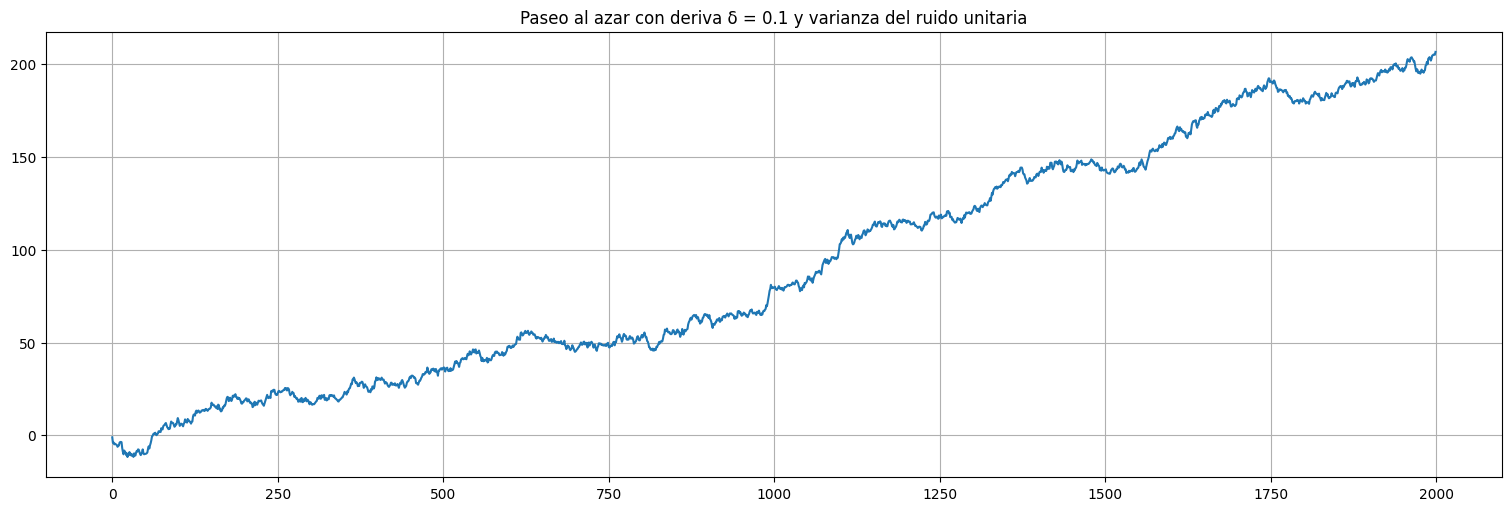

In [3]:
## Simulación de un paseo al azar con deriva
delta = 0.1
w = np.random.normal(loc=0,scale=1,size=2000)
x = np.cumsum(w+delta)
x = pd.Series(x)
x.plot()
plt.title(f"Paseo al azar con deriva δ = {delta} y varianza del ruido unitaria");

### Idea 1: Ajuste lineal

$$x_t = \beta_0 + \beta_1 t + w_t$$

con $w_t$ ruido blanco gaussiano.

In [4]:
from statsmodels.formula.api import ols
fit = ols("x~x.index.values", data=x).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      x   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 7.673e+04
Date:                Thu, 23 May 2024   Prob (F-statistic):               0.00
Time:                        01:12:47   Log-Likelihood:                -7468.2
No. Observations:                2000   AIC:                         1.494e+04
Df Residuals:                    1998   BIC:                         1.495e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -17.2022      0.453    -37.980      0.000     -18.090     -16.314
x.index.values     0.1087      0.000    277.000      0.000       0.108       0.109
==============================================================================
Omnibus:                       94.691   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.459
Skew:                          -0.539   Prob(JB):                     3.42e-23
Kurtosis:                       2.718   Cond. No.                     2.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

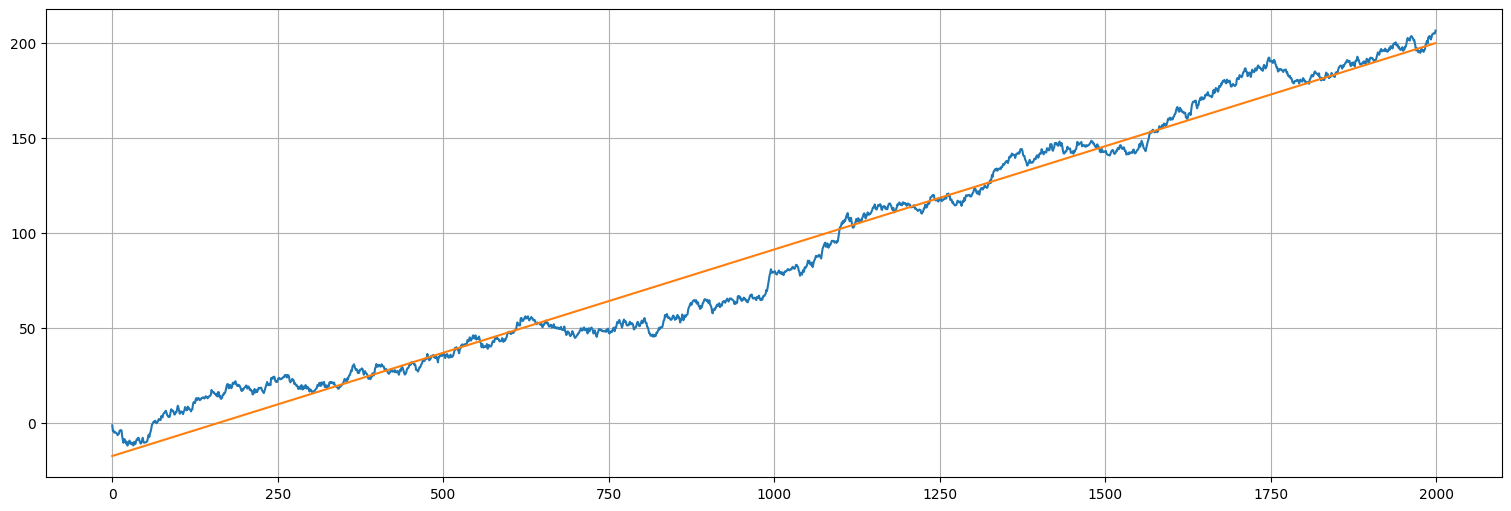

In [5]:
x.plot()
fit.fittedvalues.plot();

Miremos los residuos del ajuste:

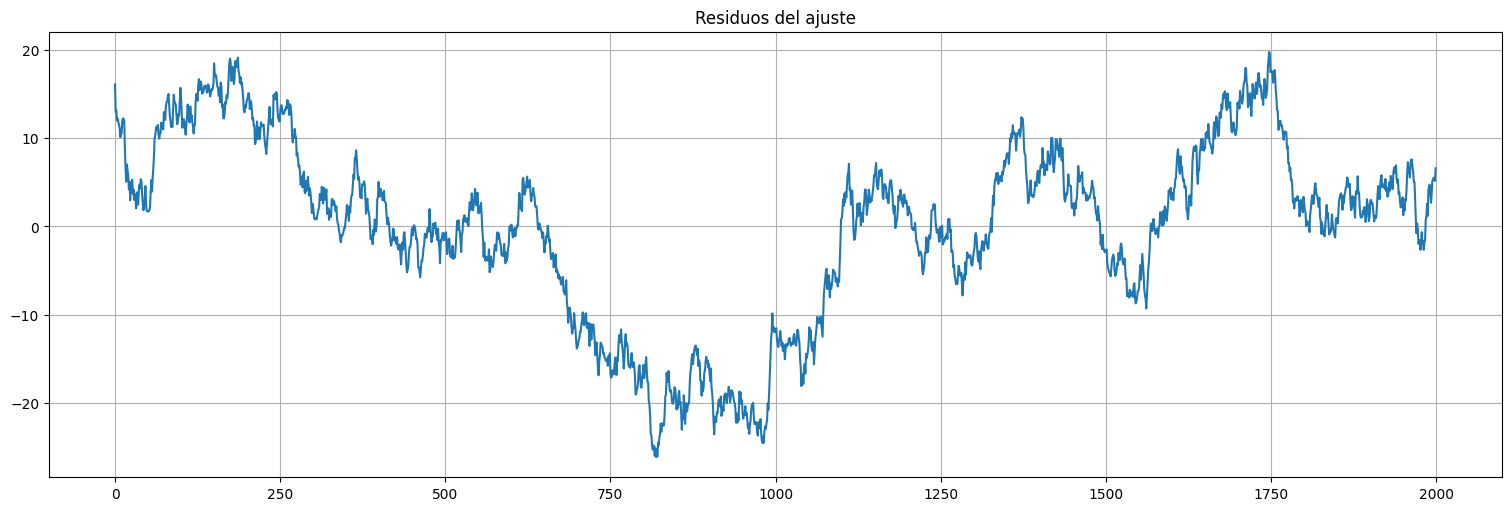

In [6]:
fit.resid.plot();
plt.title("Residuos del ajuste");

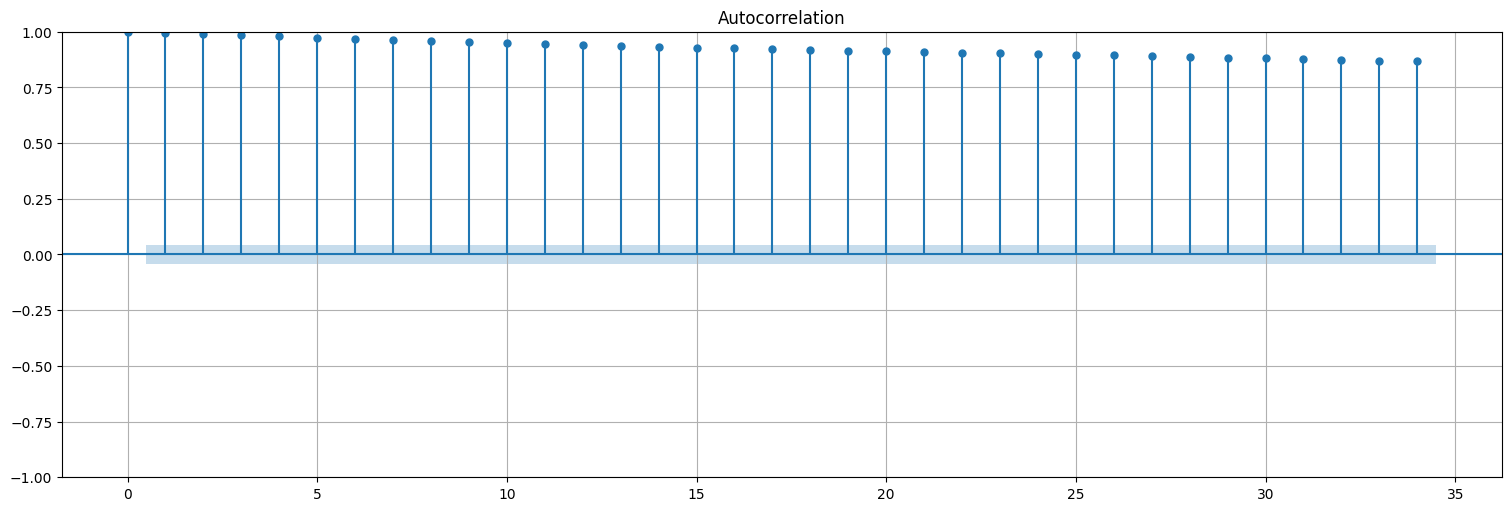

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(fit.resid, bartlett_confint=False);

### Mejor idea: tomar diferencias de la serie.

Sea:

$$y_t = x_t - x_{t-1} = x_{t-1} + \delta + w_t - x_{t-1} = \delta +w_t$$

Es decir, al tomar diferencia la serie se vuelve ruido blanco puro en este caso (estacionario), a menos de la media.

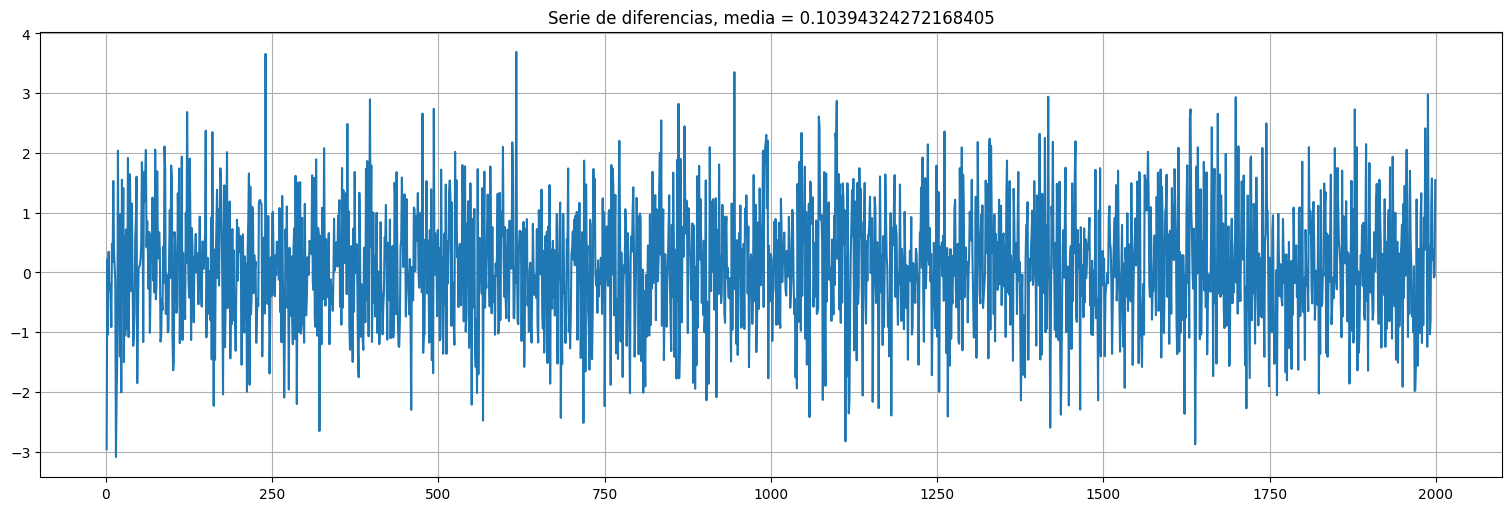

In [8]:
y = x.diff().dropna() #diferencio la serie en pandas directamente. El dropna es para eliminar el primer valor que no tengo.
y.plot()
plt.title(f"Serie de diferencias, media = {np.mean(y)}");

Miremos ahora la autocorrelación de las diferencias:

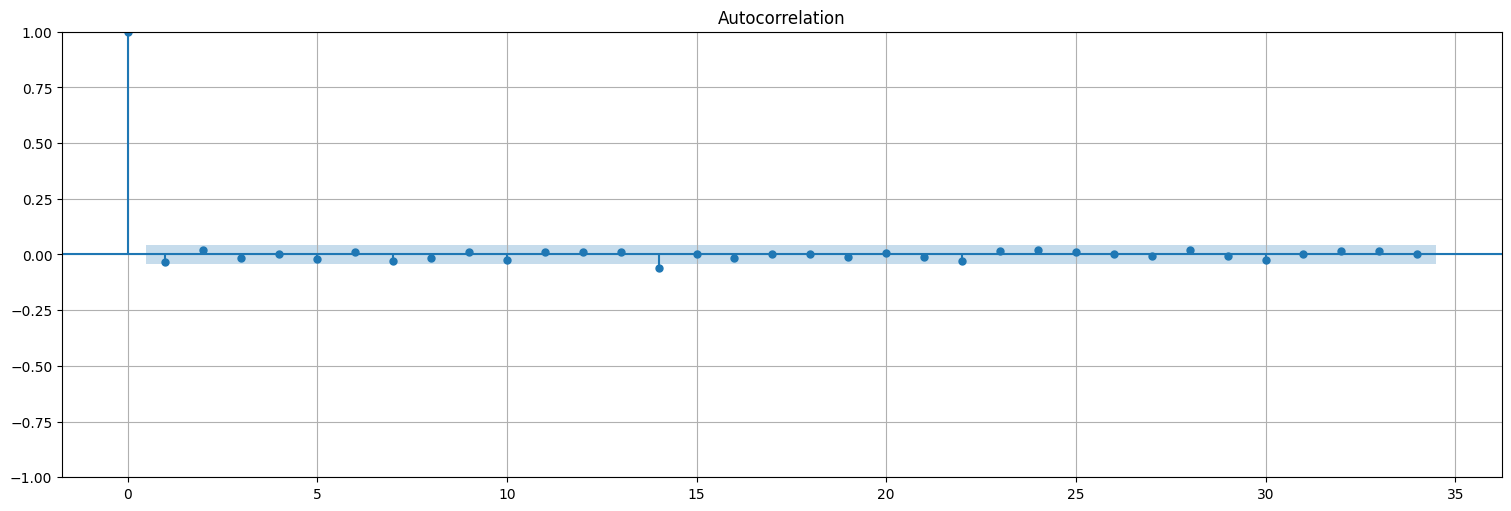

In [9]:
plot_acf(y,bartlett_confint=False);

Y también chequeamos si son aproximadamente Gaussianos:

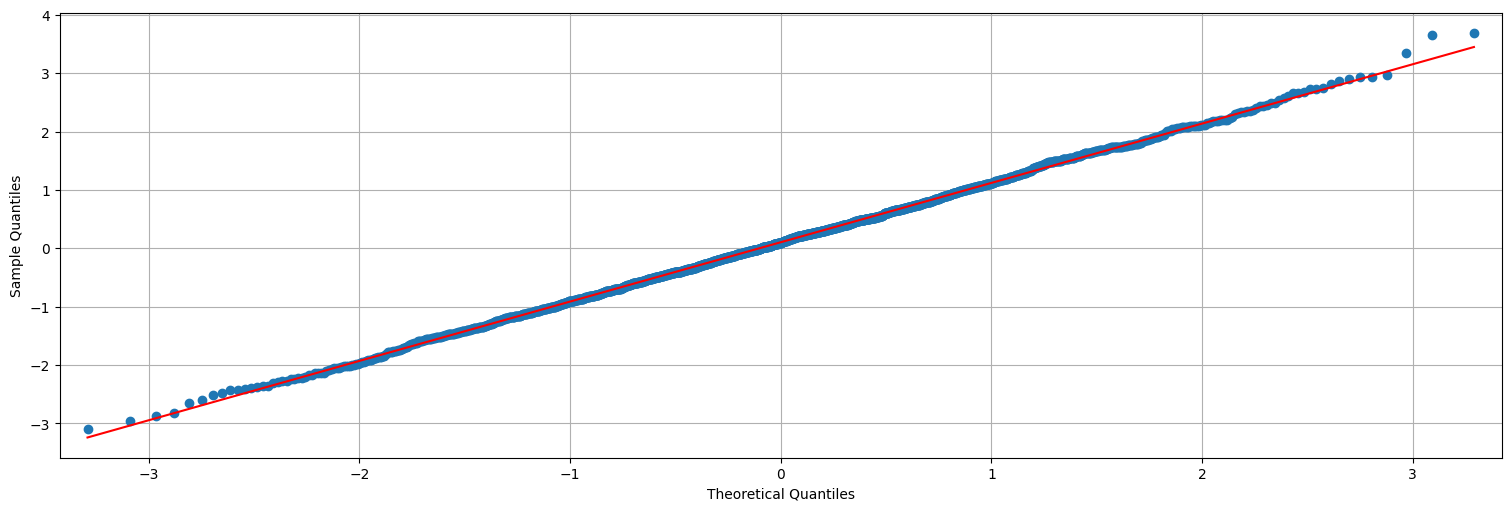

In [10]:
from statsmodels.graphics.api import qqplot
qqplot(y,line='s');

### Ejemplo no tan ejemplo...

En `data/eur_vs_usd.csv` esta la variación diaria del precio del euro frente al del dólar. Analicemos esta serie.

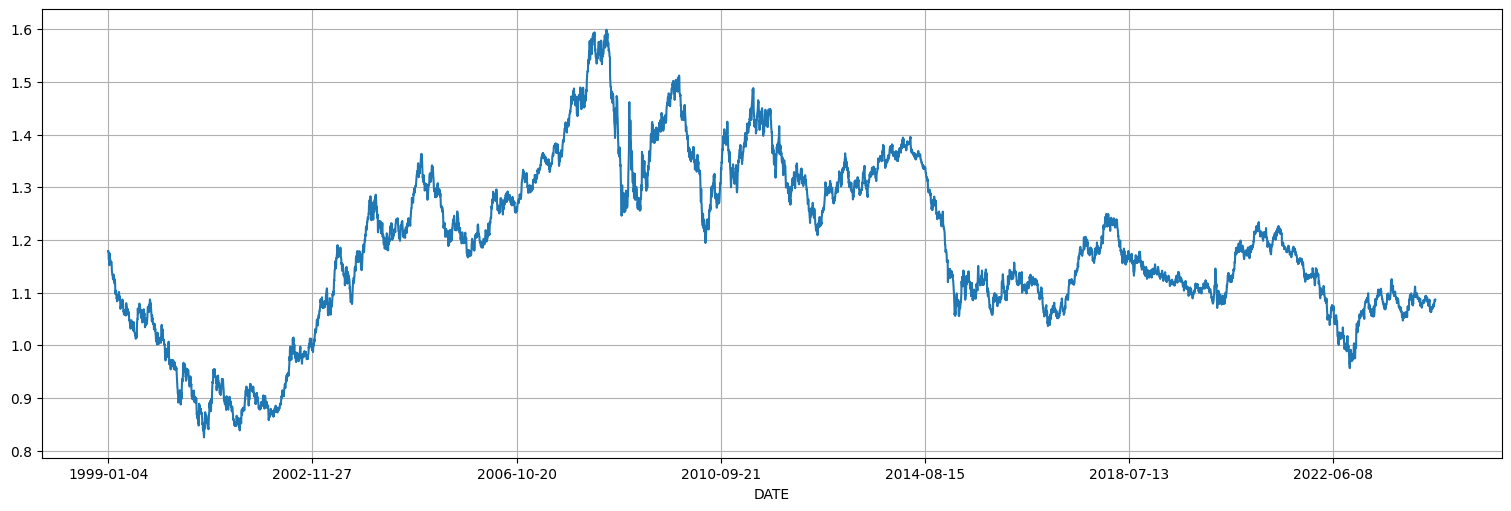

In [11]:
eur = pd.read_csv("../data/eur_vs_usd.csv").dropna()
eur = pd.Series(eur["US dollar/Euro (EXR.D.USD.EUR.SP00.A)"].values,index=eur["DATE"])
eur.plot();

Miremos la autocorrelación y vemos que no es estacionaria.

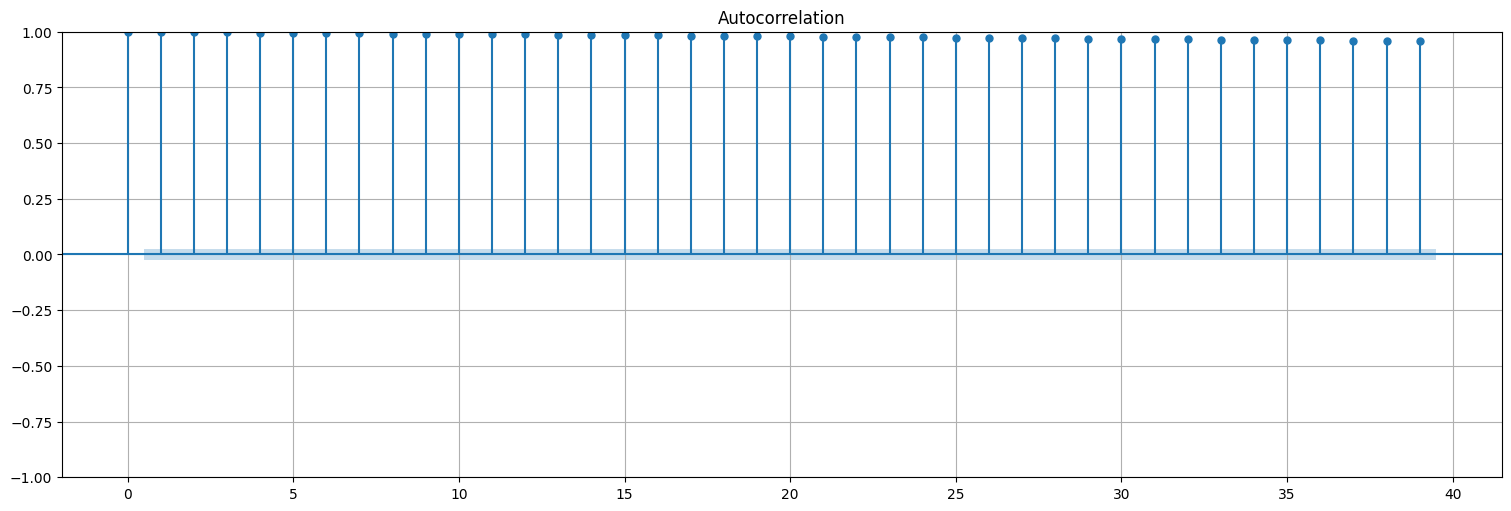

In [12]:
plot_acf(eur, bartlett_confint=False);

Probemos ahora el truco de tomar diferencias:

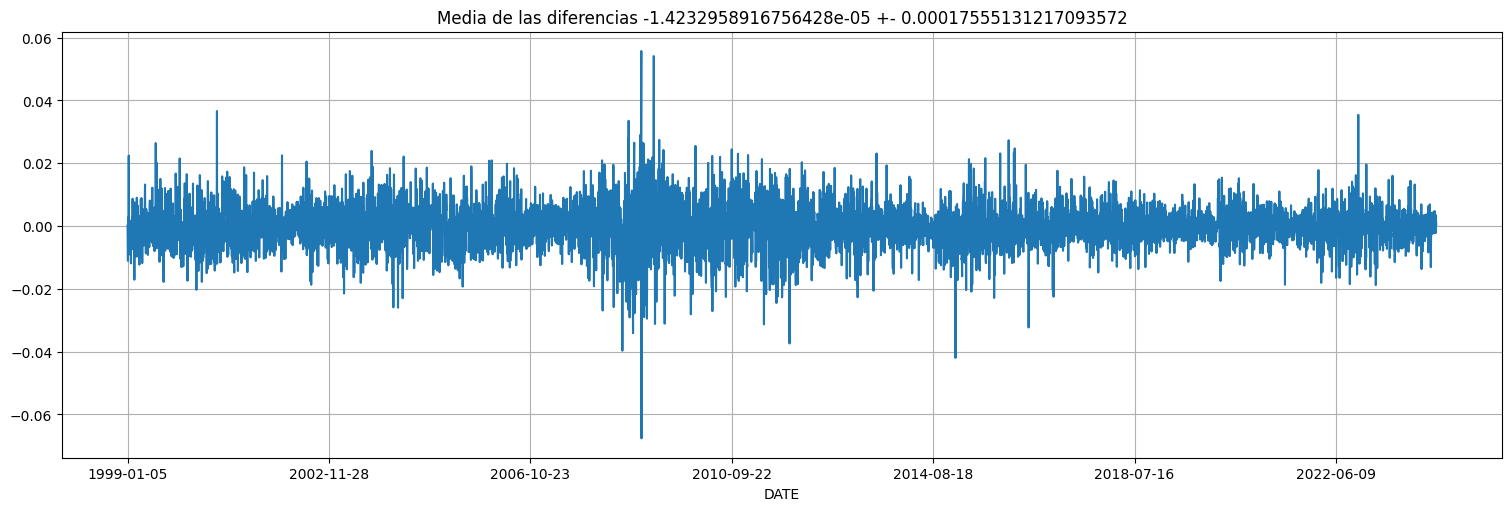

In [13]:
y = eur.diff().dropna()
y.plot();
plt.title(f"Media de las diferencias {np.mean(y)} +- {2*np.std(y)/np.sqrt(y.size)}");

Miremos la autocorrelación de la serie diferenciada, se asemeja a ruido blanco:

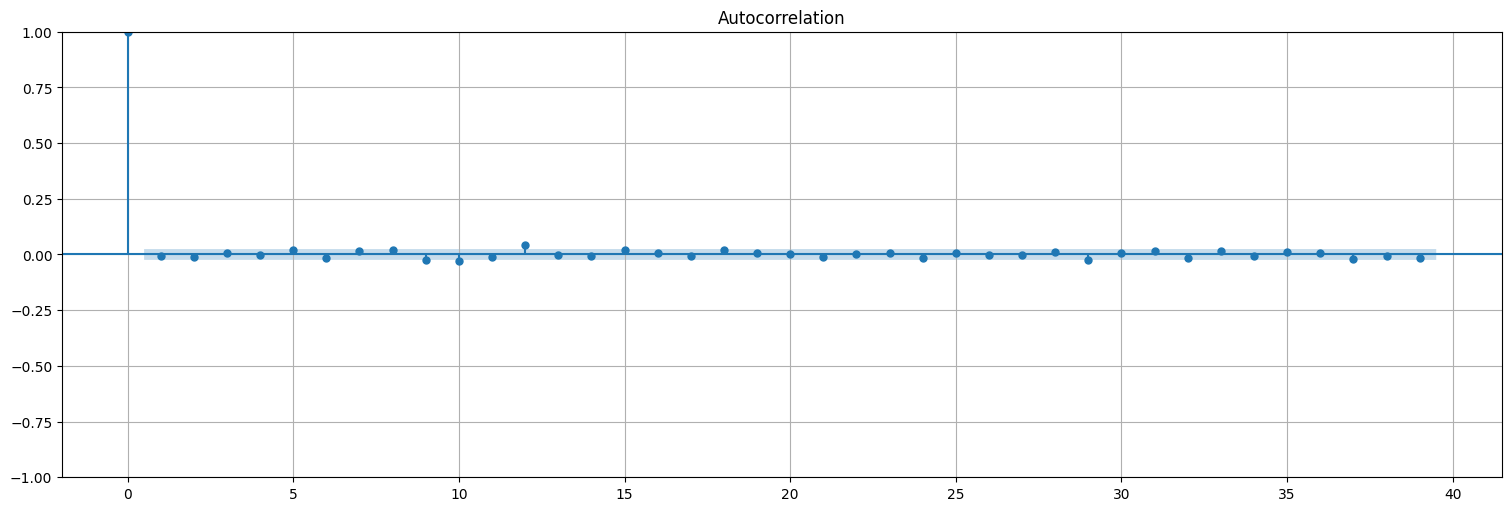

In [14]:
plot_acf(y);

Sin embargo, la serie **no es estacionaria**. Presenta momentos de mayor y menor varianza (volatilidad). En particular la distribución se aleja de una Gaussiana.

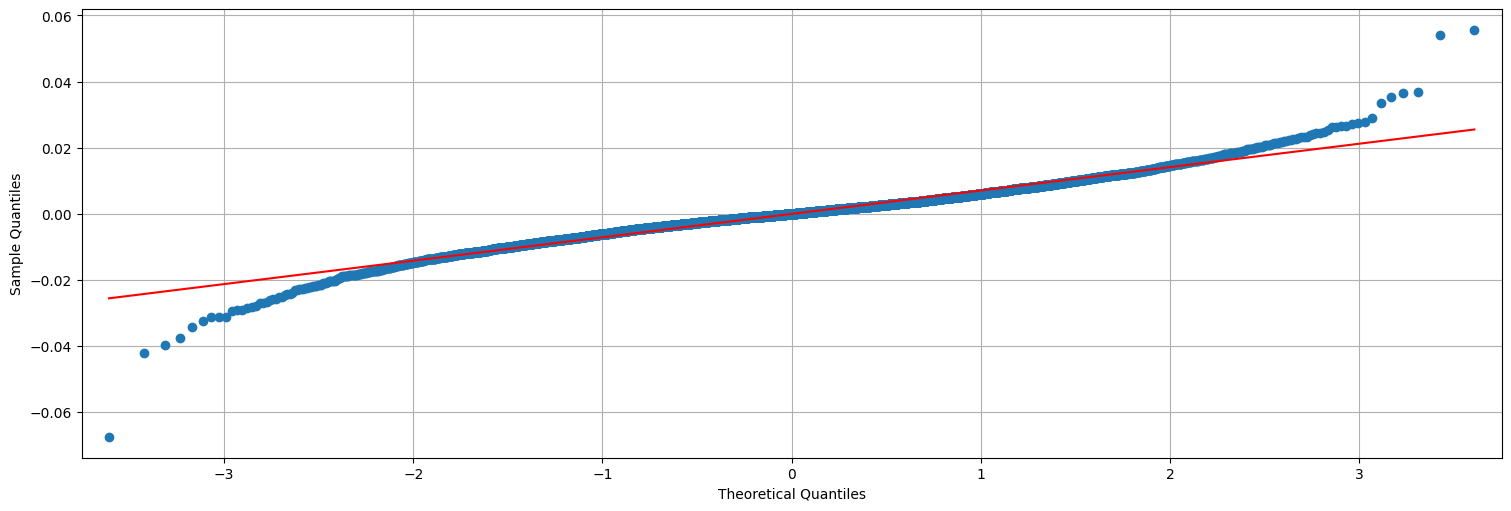

In [15]:
qqplot(y,line='s');

### Interpretación:

 * A corto plazo, la serie se comporta como un paseo al azar sin deriva (la media de las diferencias da $0$).
 *   Pero a largo plazo, la serie presenta **heterocedasticidad**, palabra difícil para decir varianza variable.

### Ejemplo: serie con trend lineal.

Supongamos que:
$$x_t = \mu_t + y_t$$

con $\mu_t = \beta_0 + \beta_1 t$ e $y_t$ estacionario. Entonces (introduciendo el operador $\nabla$ para las diferencias):

$$\nabla x_t = x_{t}- x_{t-1} = \mu_t + y_t - \mu_{t-1} - y_{t-1} = \beta_1 + \nabla y_t.$$

Es decir, la nueva serie "diferenciada" tiene una media $\beta_1$ que sale de la pendiente de la recta de tendencia y una componente estacionaria compuesta por las diferencias de la serie $y$ anterior.

**Nota:** en general, si el "trend" es un polinomio de grado $n$, diferenciar $n$ veces elimina el trend.

### Modelo ARIMA

Esto lleva a la definición del modelo $ARIMA(p,d,q)$ genérico.

**Definición:** decimos que una serie $x_t$ es $ARIMA(p,d,q)$ si:
$$y_t = \nabla^d x_t$$

es un $ARMA(p,q)$. Es decir, si diferenciar la serie $d$ veces produce un proceso $ARMA$. El nuevo parámetro $d$ es la cantidad de veces a diferenciar.

#### Ajuste de modelos ARIMA

Para el ajuste de modelos ARIMA, simplemente podemos reutilizar todo lo visto para $ARMA(p,q)$ una vez que sabemos cuántas veces hay que diferenciar ($d$). O sea, lo único nuevo es "descubrir" el $d$ necesario para que la serie quede estacionaria. Típicamente no se usa $d$ muy grande.

### Ejemplo

Consideremos que tenemos una serie $x_t$ de la forma:

$$x_t = \beta_0 + \beta_1 t + y_t$$

con $y_t$ tal que $z_t = \nabla y_t$ es autorregresivo de orden $1$ y coeficiente $\phi$.

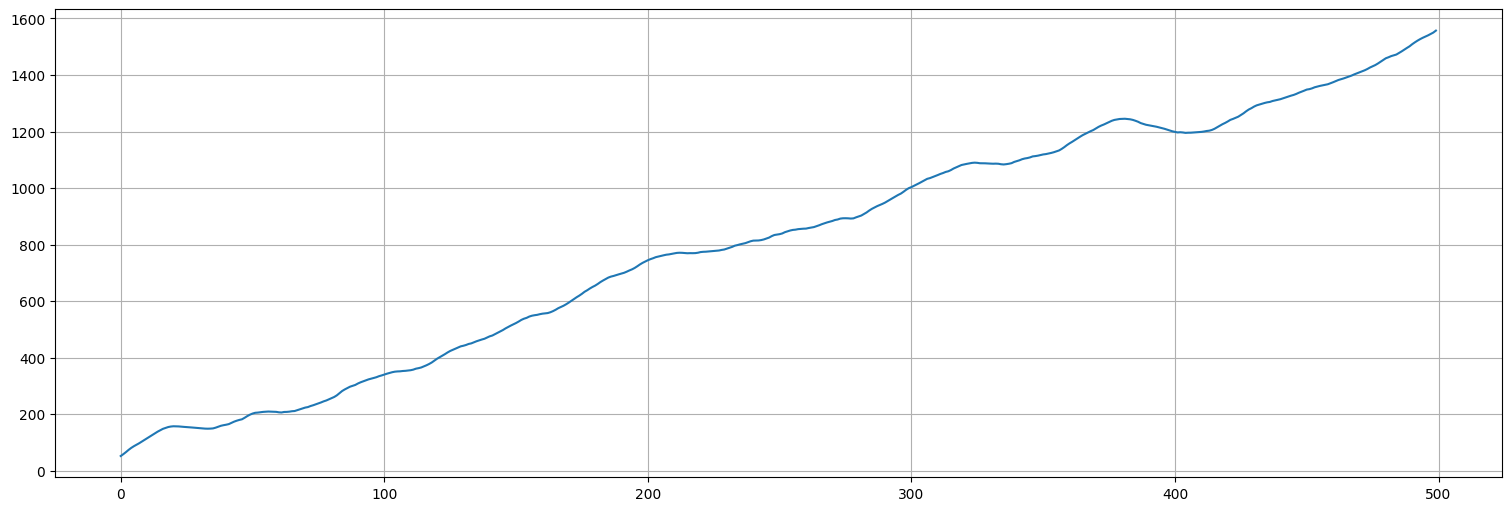

In [16]:
from statsmodels.tsa.api import arma_generate_sample
n=500
beta0 = 50
beta1 = 3
phi=0.9
z = arma_generate_sample([1,-phi],[1],n)
y = np.cumsum(z) #Esto genera la serie y a partir de la x, acumulando que es la operación contraria a diferenciar.
x = beta0+beta1*np.arange(0,n)+y
x = pd.Series(x)
x.plot();

Analicemos ahora el proceso $\nabla x$, es decir las diferencias.

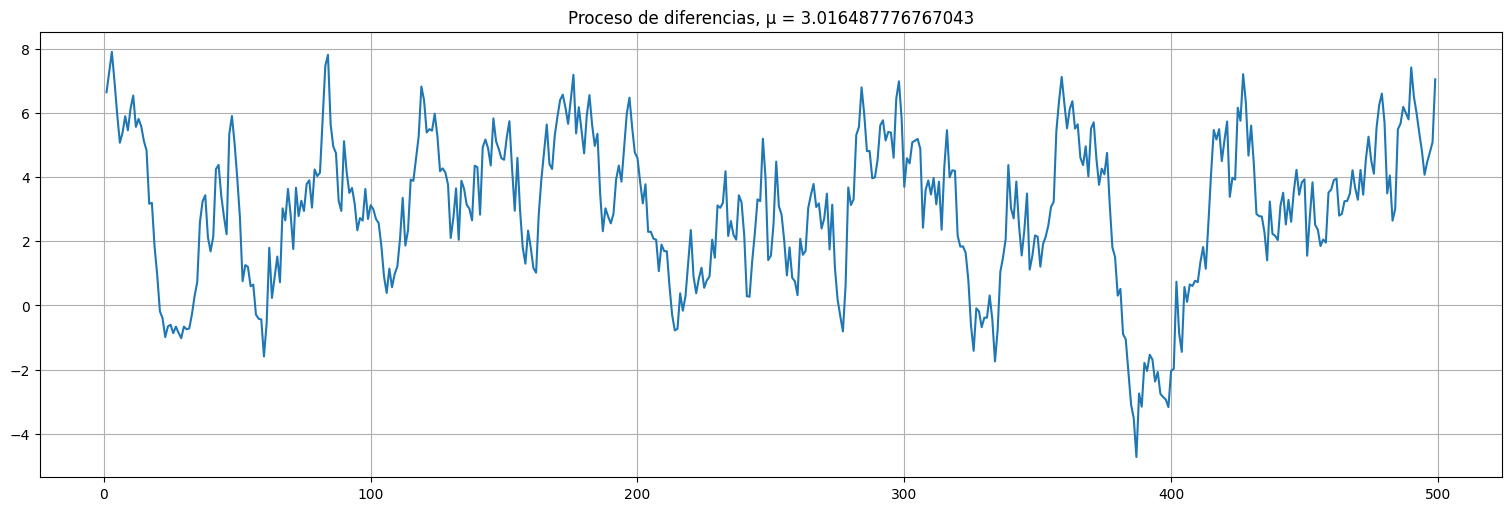

In [17]:
#Al diferenciar recupero z pero con media beta1.
dx = x.diff().dropna()
dx.plot()
plt.title(f"Proceso de diferencias, μ = {np.mean(dx)}");

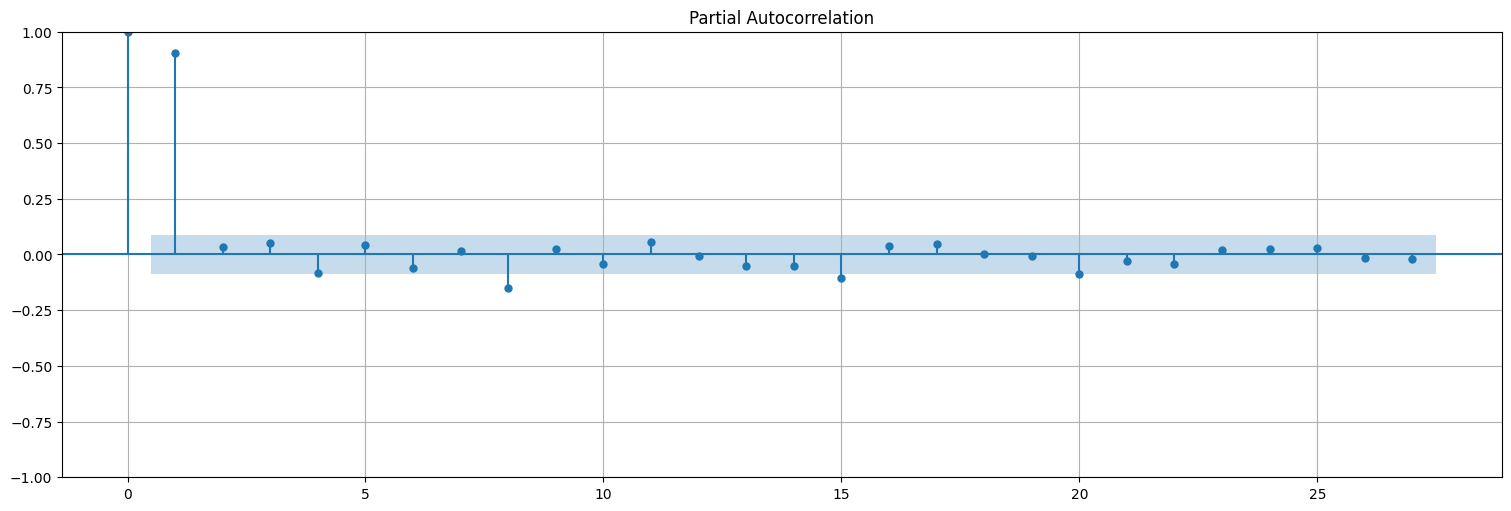

In [18]:
#las correlaciones confirman la estacionariedad (parece un AR(1) en este caso)
plot_pacf(dx);

In [19]:
##Ajusto directo un ARIMA a la serie x usando statsplots
## el parámetro trend="t" permite que la serie diferenciada conserve el drift 
## la media del resultado de diferenciar
from statsmodels.tsa.api import ARIMA

fit = ARIMA(x,order=(1,1,0), trend="t").fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -689.497
Date:                Thu, 23 May 2024   AIC                           1384.993
Time:                        01:12:50   BIC                           1397.631
Sample:                             0   HQIC                          1389.953
                                - 500                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.1664      0.466      6.800      0.000       2.254       4.079
ar.L1          0.9106      0.020     46.682      0.000       0.872       0.949
sigma2         0.9250      0.062     14.933      0.000       0.804       1.046
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                 3.76
Prob(Q):                              0.54   Prob(JB):                         0.15
Heteroskedasticity (H):               1.08   Skew:                             0.20
Prob(H) (two-sided):                  0.60   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Analicemos los residuos del ajuste:

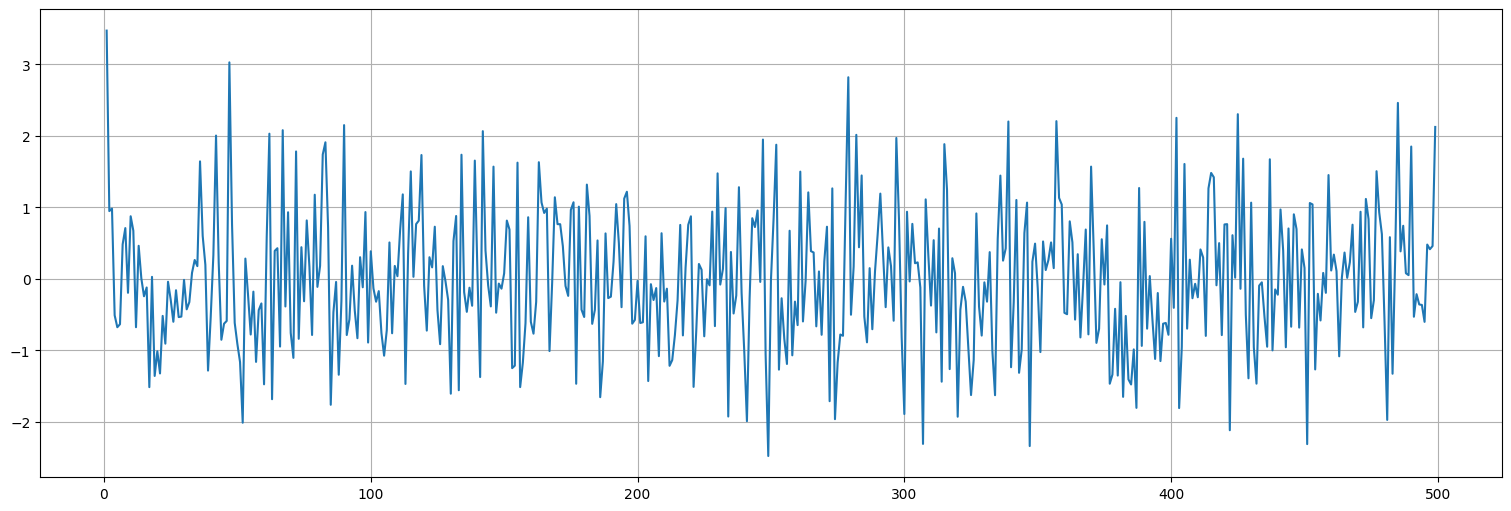

In [20]:
res = fit.resid.iloc[1:] #saco el primer residuo porque no tiene sentido luego de diferenciar
res.plot();

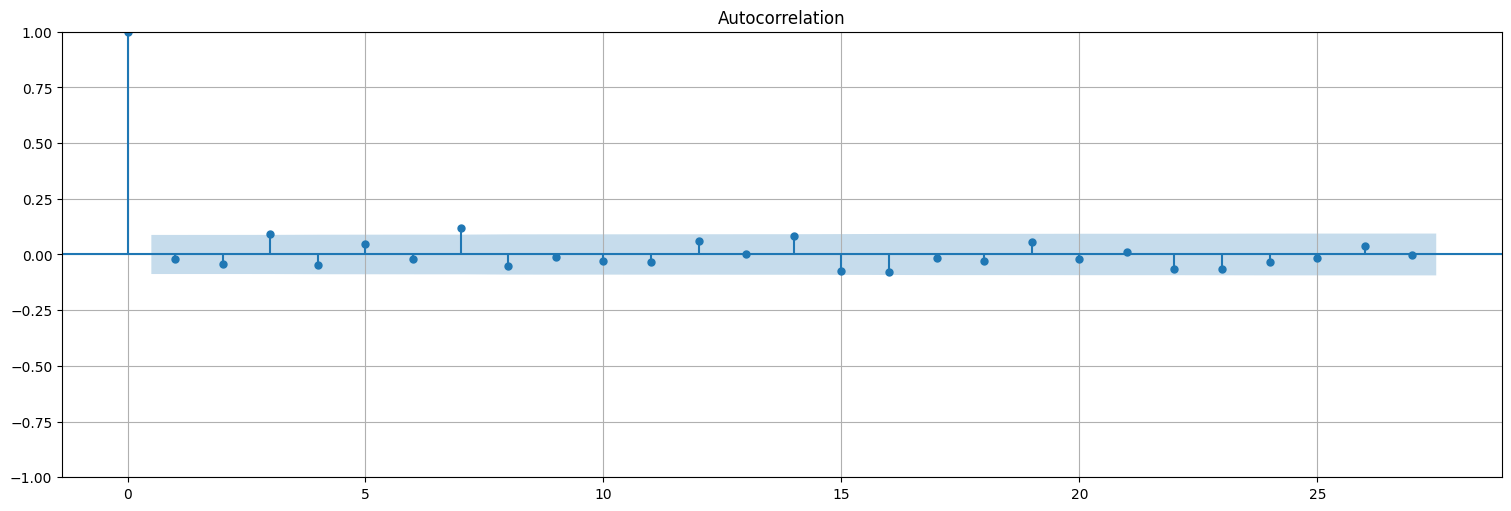

In [21]:
plot_acf(res);

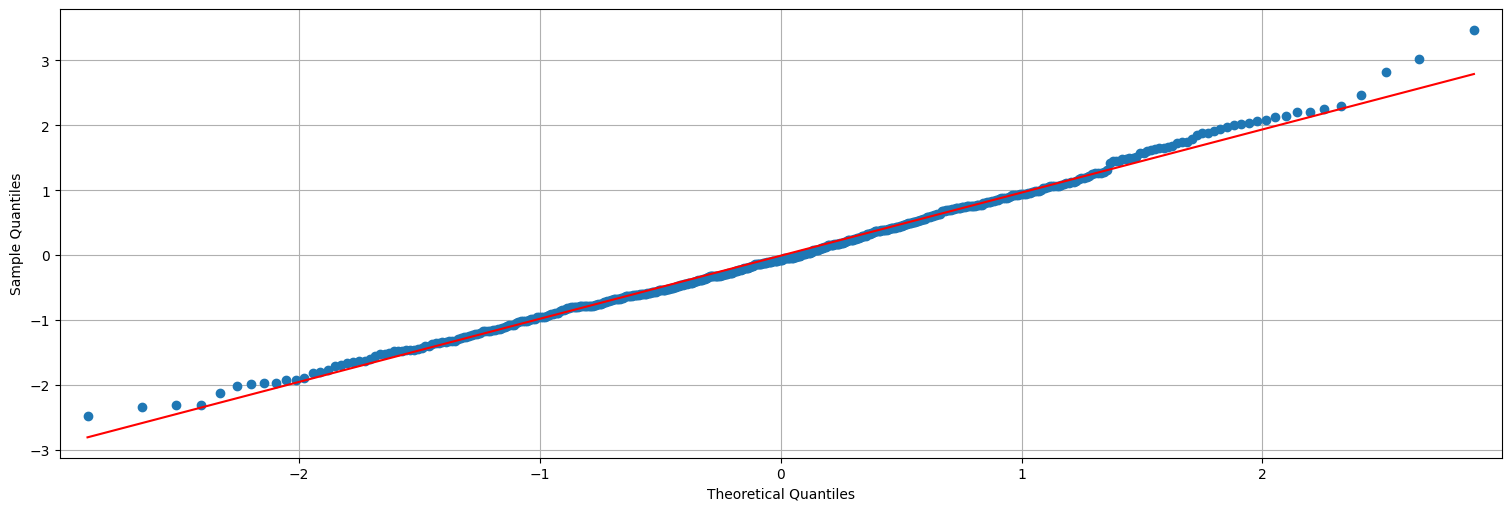

In [22]:
qqplot(res,line="s");

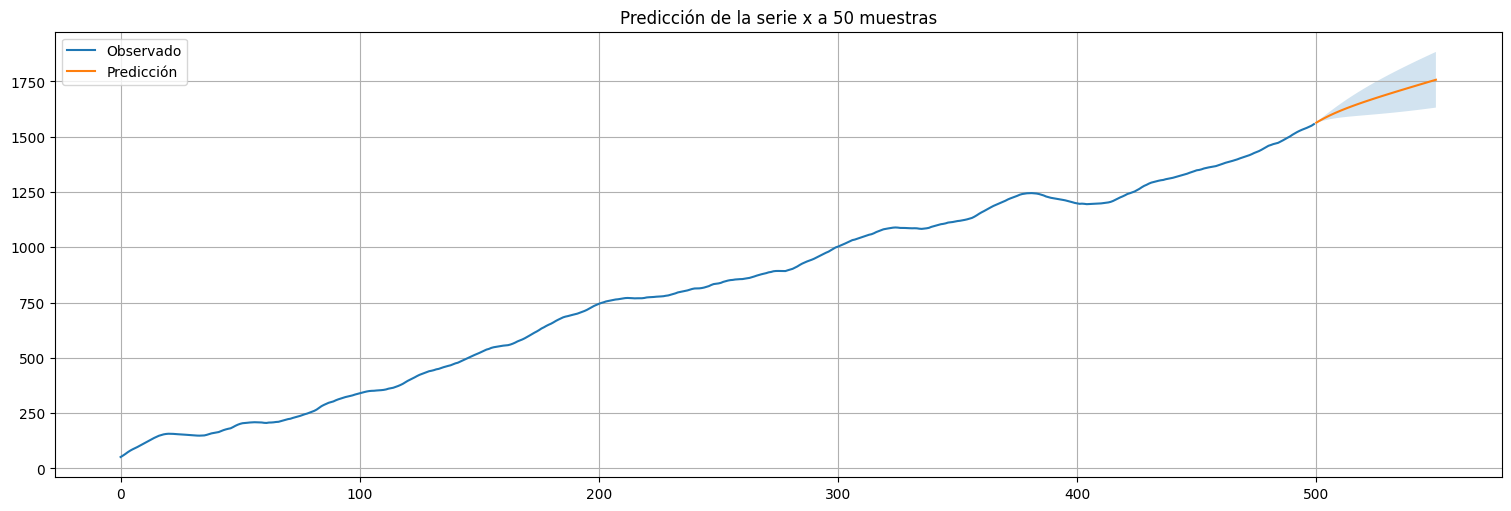

In [23]:
#Usamos el modelo ajustado para predecir a futuro
h = 50 #horizonte de predicción
predicciones = fit.get_prediction(start=x.size,end=x.size+h)
xhat = predicciones.predicted_mean
confint = predicciones.conf_int(alpha=0.05) #alpha es la confianza del intervalo
x.plot()
xhat.plot()
plt.legend(["Observado","Predicción"])
plt.fill_between(xhat.index,confint["lower y"], confint["upper y"], alpha=0.2);
plt.title(f"Predicción de la serie x a {h} muestras");

## Resumen: ARMA, ARIMA, ajuste, predicción.

Con todo lo visto, hemos construido una especie de receta (debida a Box-Jenkins) para trabajar con este tipo de modelos, a saber:
 * Graficar los datos
 * Trasnformar los datos (por ejemplo, transformación logarítmica, o detrend o ambos, diferenciación).
 * Identificar los órdenes de dependencia (acf, pacf).
 * Estimación de parámetros (fit, básicamente mínimos cuadrados o máxima verosimilitud).
 * Diagnóstico (análisis de residuos por ejemplo).
 * Elección del modelo (criterios de información tipo AIC, evitar overfitting, etc.)
 * Predicción en base a estimadores lineales calculados recursivamente e intervalos de confianza.
 

## Ejemplo completo: la serie GNP

Esta serie contiene el Producto Nacional Bruto (GNP) de Estados Unidos medido trimestralmente desde 1947 a 2002.

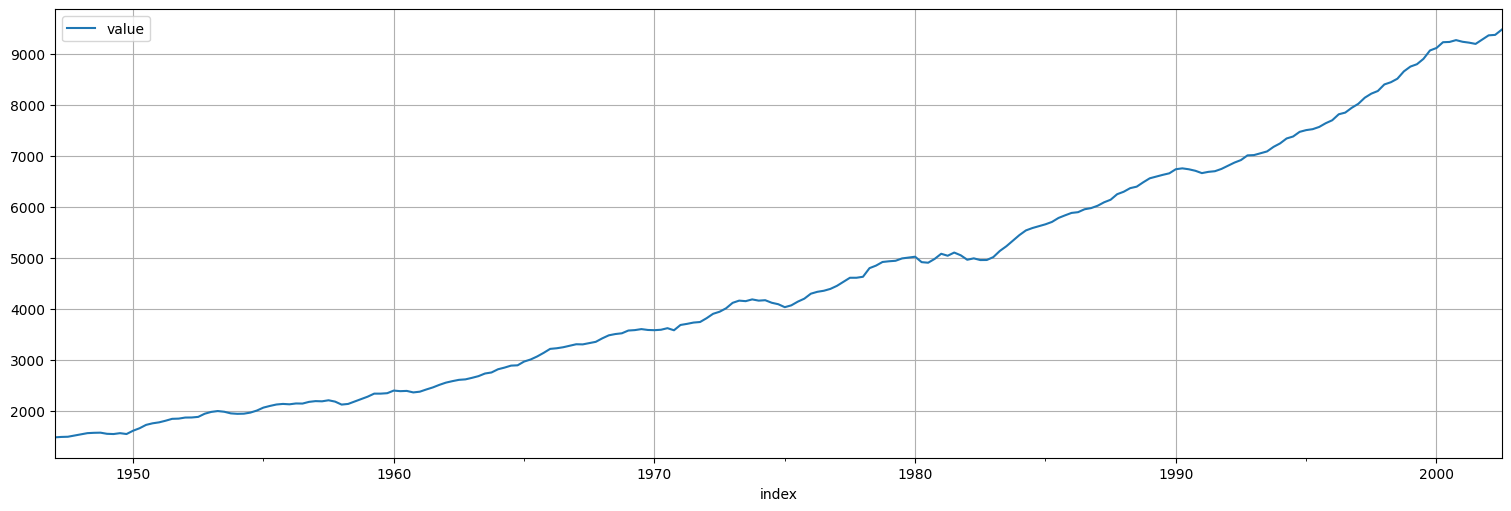

In [24]:
gnp = astsa.gnp
gnp.plot();

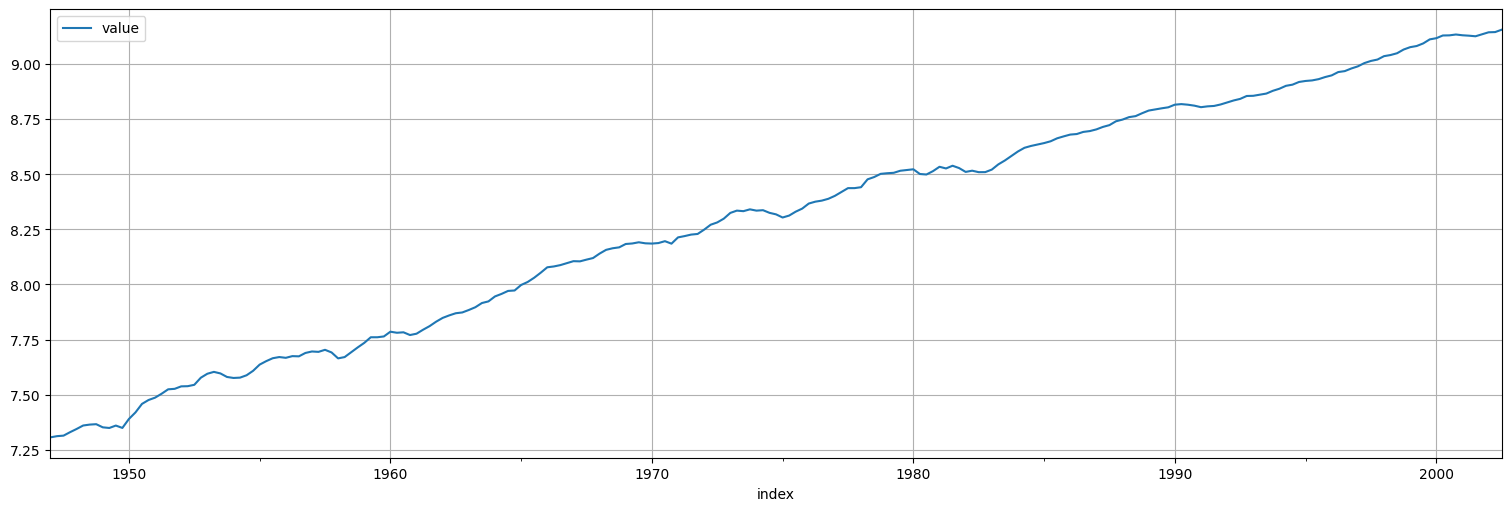

In [25]:
#Transformo por log
x=np.log(gnp)
x.plot();

Hago la ACF solo par ver que no es estacionaria

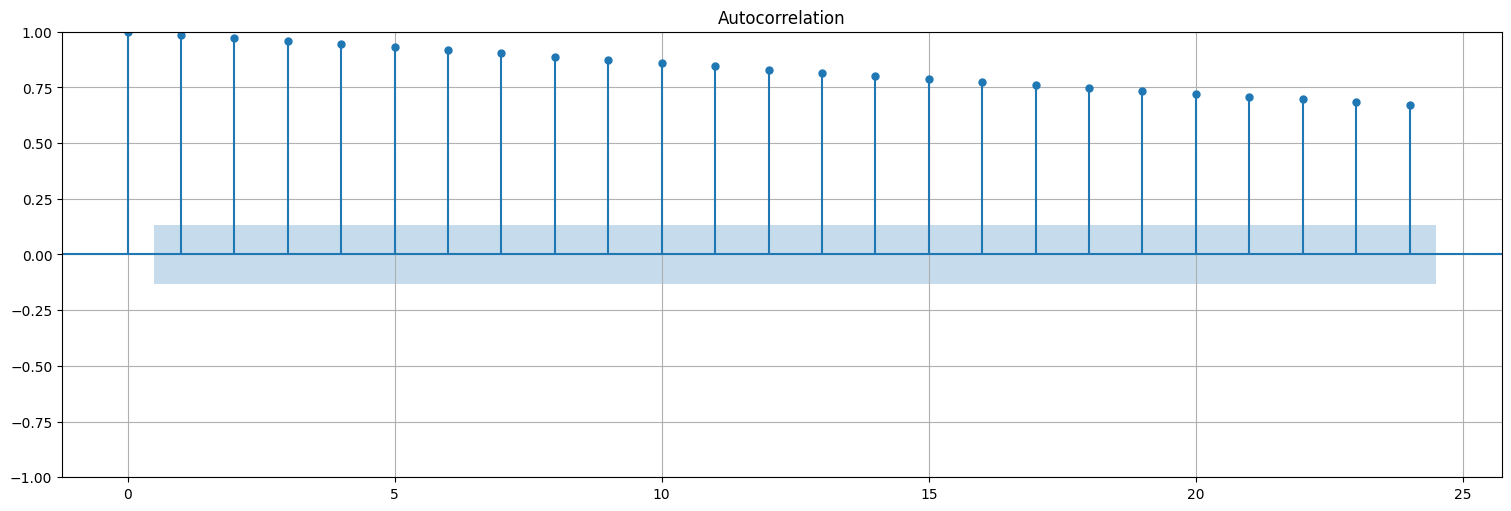

In [26]:
plot_acf(x, bartlett_confint=False);

Diferencio la serie una vez y logro estacionariedad

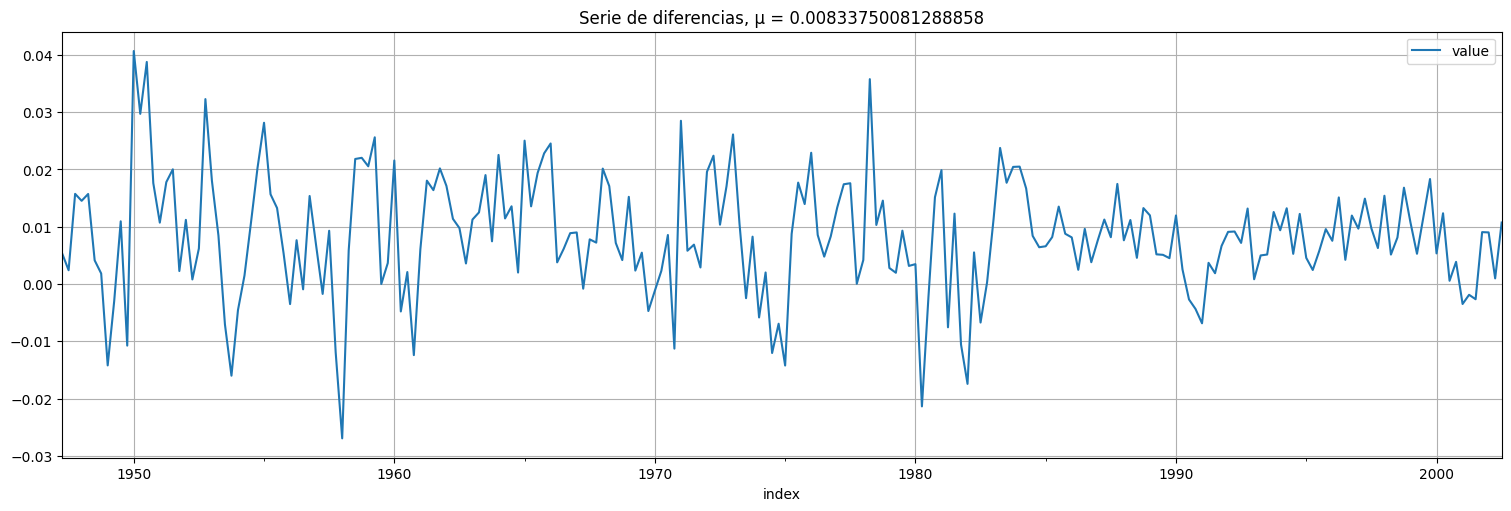

In [27]:
y=x.diff().dropna()
y.plot()
plt.title(f"Serie de diferencias, μ = {np.mean(y)}");

Analizamos ACF y PACF

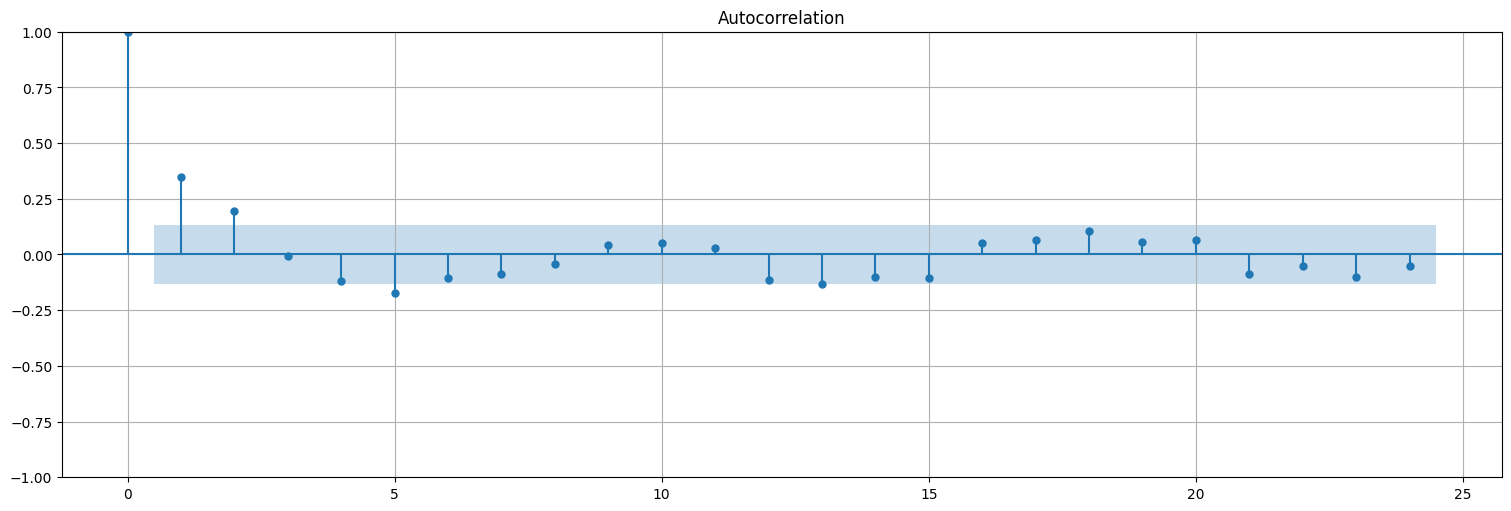

In [28]:
plot_acf(y, bartlett_confint=False);

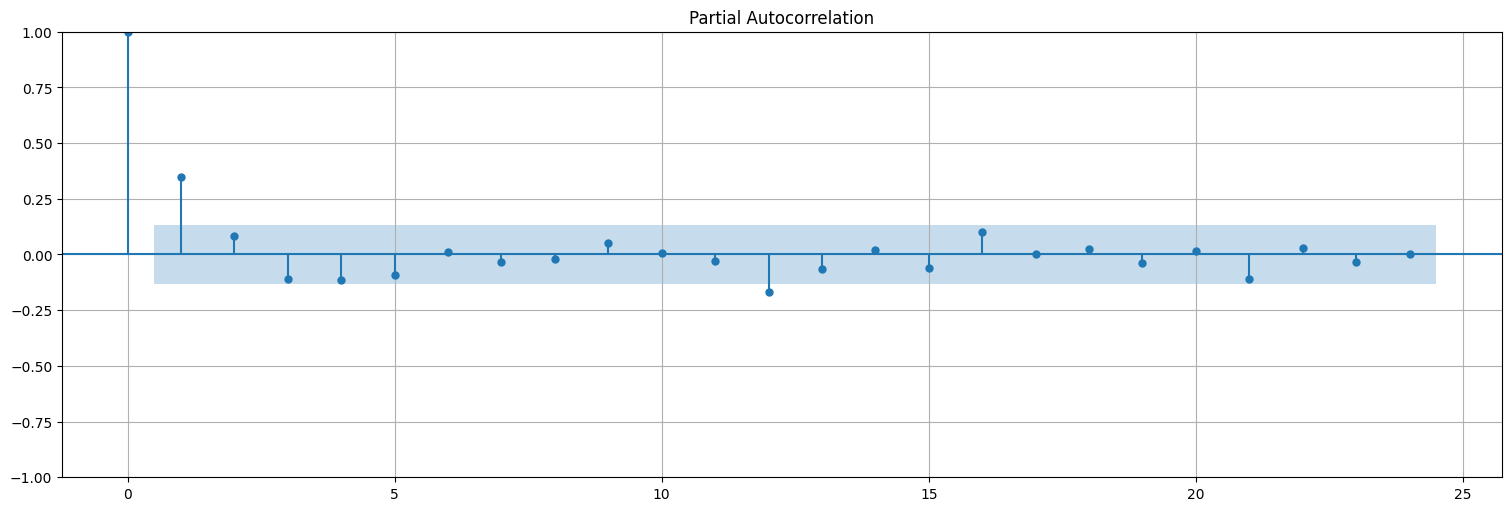

In [29]:
plot_pacf(y);

Mirando lo anterior podemos inclinarnos por varios modelos para $x$:

* ARIMA(1,1,0) ya que diferenciamos una vez y vemos que la PACF corta en 1.
* ARIMA(0,1,2) ya que diferenciamos una vez y vemos que la ACF corta en 2.
* Otras posibilidades a testear. Probemos y hagamos diagnóstico

#### ARIMA(1,1,0)

In [30]:
fit = ARIMA(x,order=(1,1,0), trend="t").fit()
res = fit.resid[1:]; #acordarse de sacar el primero
print(f"RMSE: {np.std(res)}")
fit.summary()

RMSE: 0.009502645075030267


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  223
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 718.610
Date:                Thu, 23 May 2024   AIC                          -1431.220
Time:                        01:12:52   BIC                          -1421.012
Sample:                    03-31-1947   HQIC                         -1427.099
                         - 09-30-2002                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0083      0.001      8.297      0.000       0.006       0.010
ar.L1          0.3481      0.055      6.288      0.000       0.240       0.457
sigma2      9.023e-05   6.47e-06     13.943      0.000    7.76e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                23.64
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

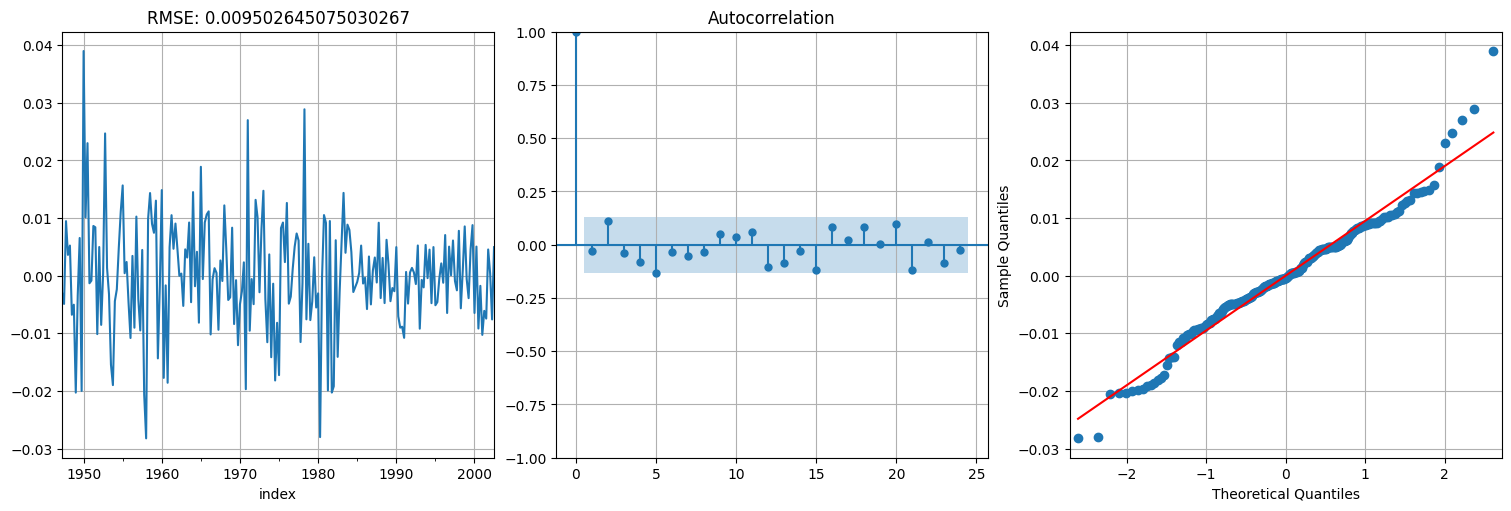

In [31]:
fig, axs = plt.subplots(1, 3)
res.plot(ax=axs[0])
axs[0].title.set_text(f"RMSE: {np.std(res)}")
plot_acf(res, ax=axs[1], bartlett_confint=False)
qqplot(res,line='s', ax=axs[2]);

#### ARIMA(0,1,2)

In [32]:
fit = ARIMA(x,order=(0,1,2), trend="t").fit()
res = fit.resid[1:]; #acordarse de sacar el primero
print(f"RMSE: {np.std(res)}")
fit.summary()

RMSE: 0.009446780365192323


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  223
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 719.908
Date:                Thu, 23 May 2024   AIC                          -1431.816
Time:                        01:12:52   BIC                          -1418.206
Sample:                    03-31-1947   HQIC                         -1426.321
                         - 09-30-2002                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0083      0.001      8.389      0.000       0.006       0.010
ma.L1          0.3067      0.054      5.649      0.000       0.200       0.413
ma.L2          0.2249      0.056      4.028      0.000       0.115       0.334
sigma2       8.92e-05   6.49e-06     13.752      0.000    7.65e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                21.82
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

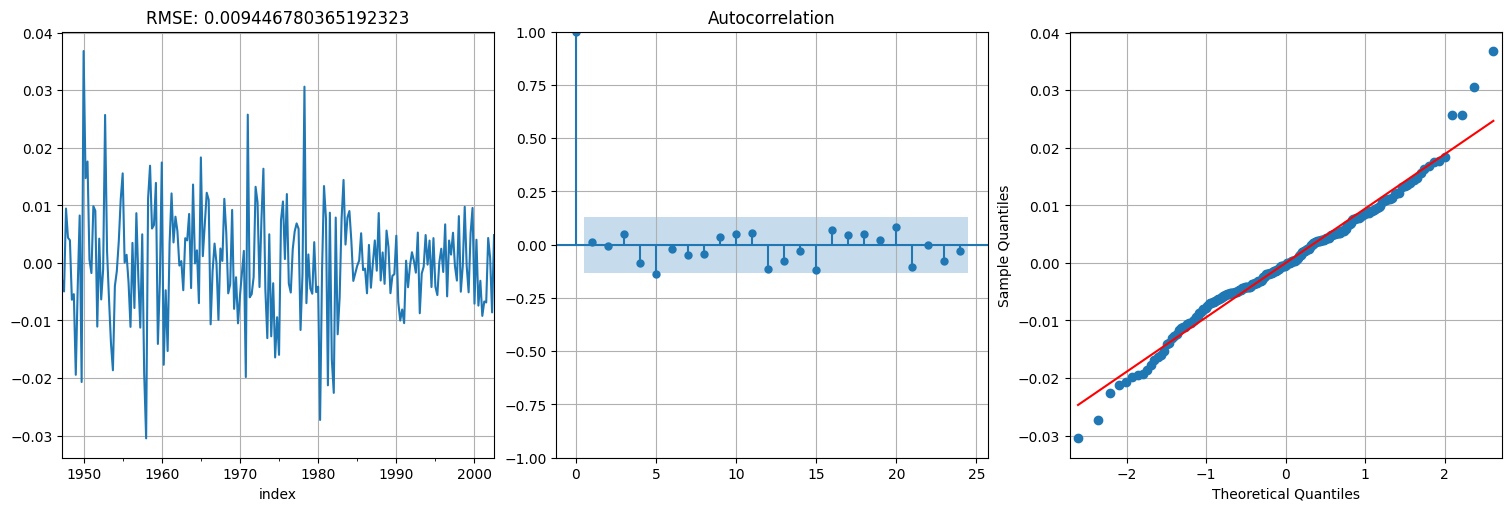

In [33]:
fig, axs = plt.subplots(1, 3)
res.plot(ax=axs[0])
axs[0].title.set_text(f"RMSE: {np.std(res)}")
plot_acf(res, ax=axs[1], bartlett_confint=False)
qqplot(res,line='s', ax=axs[2]);

Como vemos, dan bastante parecidos, con leve ventaja para el $MA(2)$. Probemos combinar ambas en un **ARIMA(1,1,1)**, es decir, media móvil de orden 1 y autorregresivo de orden 1 luego de diferenciar.

In [34]:
fit = ARIMA(x,order=(1,1,1), trend="t").fit()
res = fit.resid[1:]; #acordarse de sacar el primero
print(f"RMSE: {np.std(res)}")
fit.summary()

RMSE: 0.00948490439935017


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  223
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 719.022
Date:                Thu, 23 May 2024   AIC                          -1430.044
Time:                        01:12:53   BIC                          -1416.433
Sample:                    03-31-1947   HQIC                         -1424.549
                         - 09-30-2002                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0083      0.001      7.651      0.000       0.006       0.010
ar.L1          0.4854      0.162      2.992      0.003       0.167       0.803
ma.L1         -0.1552      0.178     -0.871      0.384      -0.505       0.194
sigma2      8.994e-05   6.55e-06     13.728      0.000    7.71e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                22.25
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

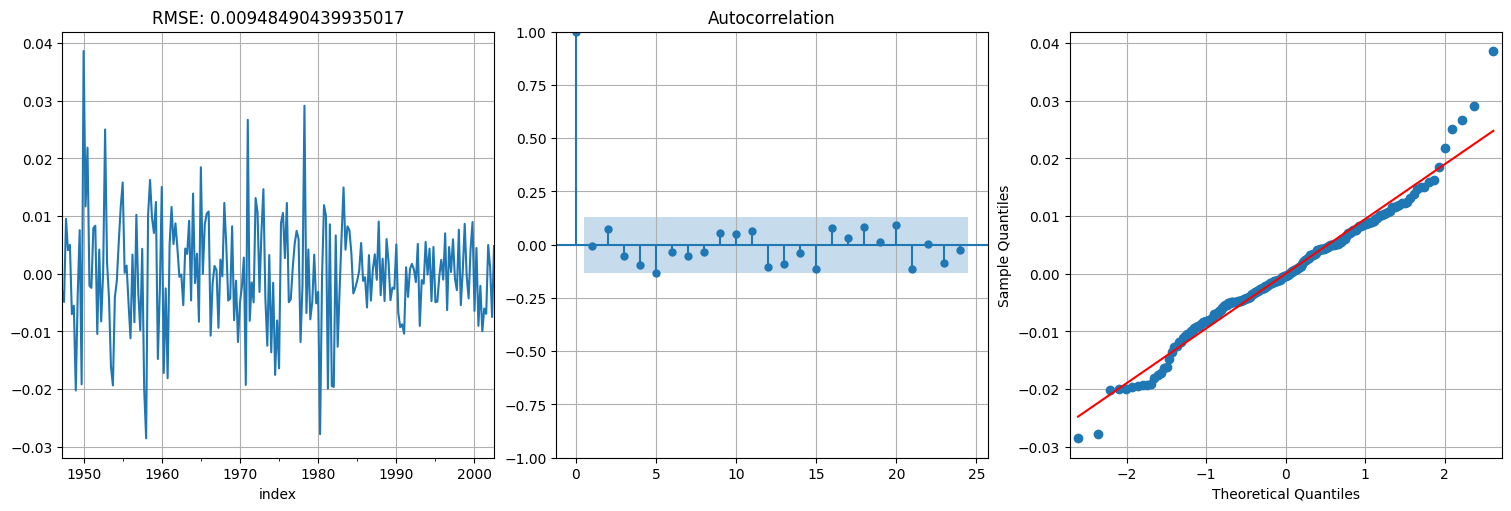

In [35]:
fig, axs = plt.subplots(1, 3)
res.plot(ax=axs[0])
axs[0].title.set_text(f"RMSE: {np.std(res)}")
plot_acf(res, ax=axs[1], bartlett_confint=False)
qqplot(res,line='s', ax=axs[2]);

### Estadístico de Ljung-Box-Pierce

La serie anterior de residuos parece haber quedado "blanca". Sin embargo, es bueno disponer de un test que permita evaluar si la ACF en su conjunto es razonablemente blanca en lugar de mirar lag a lag. Para ello se usa el *estadístico de Ljung-Box-Pierce*.

$$Q = n(n+2) \sum_{h=1}^H \frac{\hat{\rho}^2_e(h)}{n-h},$$

donde $H$ es una ventana. La idea de este estadístico es acumular varias correlaciones en la ventana $H$ para ver si en su conjunto son todas despreciables (en lugar de una a una).

El estadístico $Q$ es asintóticamente $\chi^2_{H-p-q}$ por lo que si el valor de $Q$ es grande (más que el cuantil $\alpha$ de la $\chi^2$) rechazamos la hipótesis de independencia.

En general lo que se hace es mirar los $p$-valores, es decir cuánta probabilidad queda a la derecha de $Q$. Si es pequeño (ej: $p<0.05$) se rechaza la hipótesis.

In [36]:
from statsmodels.stats.api import acorr_ljungbox
acorr_ljungbox(res,10)

,lb_stat,lb_pvalue
1,0.003281,0.954324
2,1.197290,0.549556
3,1.811029,0.612538
4,3.849914,0.426699
5,8.023301,0.154956
6,8.289443,0.217656
7,8.906550,0.259435
8,9.149590,0.329834
9,9.838461,0.363720
10,10.428248,0.403758


### Predicción:

Como último paso pasamos a la predicción a $2$ años (8 trimestres):


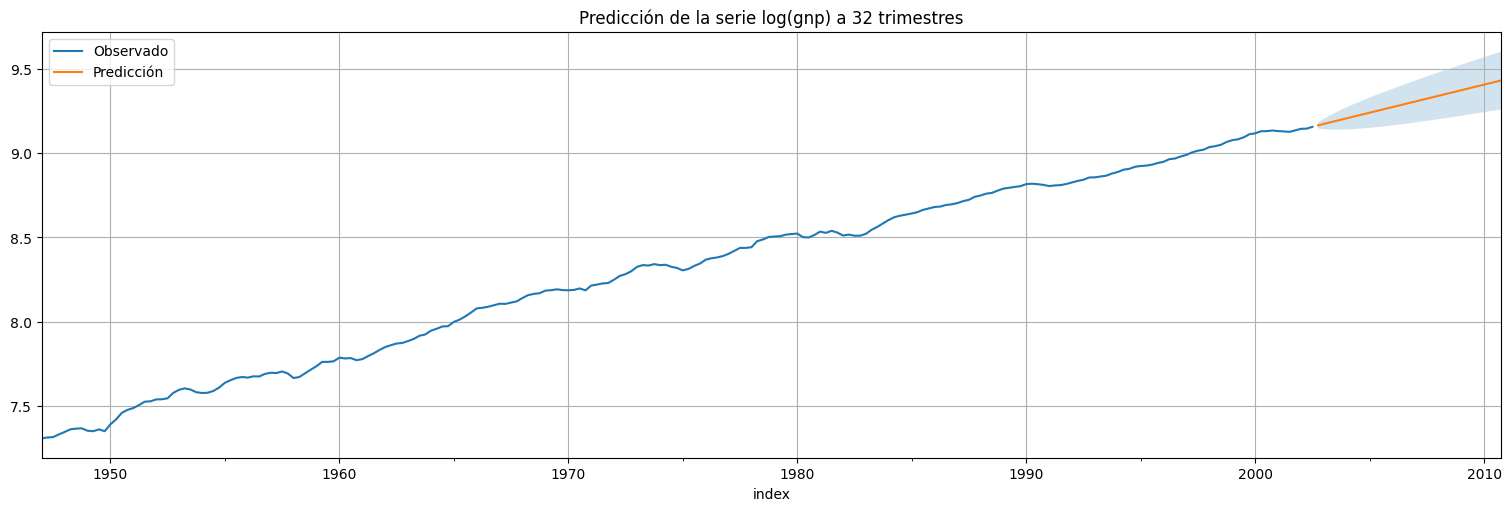

In [37]:
#Usamos el modelo ajustado para predecir a futuro
h = 32 #horizonte de predicción
predicciones = fit.get_prediction(start=gnp.size,end=gnp.size+h)
xhat = predicciones.predicted_mean
confint = predicciones.conf_int(alpha=0.05) #alpha es la confianza del intervalo
x.plot()
xhat.plot()
plt.legend(["Observado","Predicción"])
plt.fill_between(xhat.index,confint["lower value"], confint["upper value"], alpha=0.2);
plt.title(f"Predicción de la serie log(gnp) a {h} trimestres");

Ahora podemos volver a la variable original, deshaciendo la transformación $x\to \log(x)$ mediante $y\to \exp(y)$:

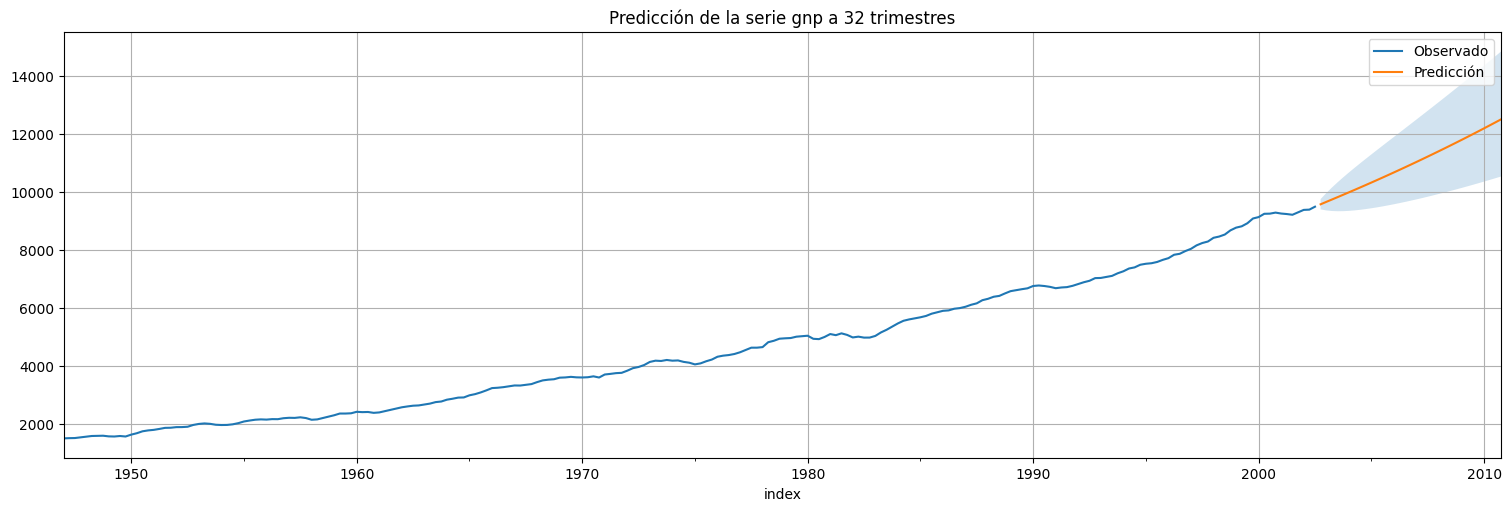

In [38]:
gnp.plot()
estimated_gnp = np.exp(xhat)
confint_exp = np.exp(confint)
estimated_gnp.plot()
plt.legend(["Observado","Predicción"])
plt.fill_between(xhat.index,confint_exp["lower value"], confint_exp["upper value"], alpha=0.2);
plt.title(f"Predicción de la serie gnp a {h} trimestres");

## Modelos ARIMA estacionales (SARIMA)

Una variante muy utilizada de los modelos ARMA (ARIMA) es aquella que agrega dependencia *estacional*. Es decir, existe algún período conocido $s$ de la serie llamado *componente estacional* que se conoce tiene influencia en el valor actual. Por ejemplo $s=12$ en series anuales muestreadas mensualmente.

### Ejemplo (AR estacional puro)

Supongamos que la serie sigue la siguiente ecuación:

$$x_{t} = \Phi x_{t-12} + w_t$$

con $\Phi$ un coeficiente y $w_t$ ruido blanco Gaussiano de varianza $\sigma^2_w$

El proceso anterior lo podemos pensar simplemente como un proceso $AR(12)$, pero cuyos coeficientes intermedios son todos $0$.

Coeficientes autorregresivos = [ 1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.9]


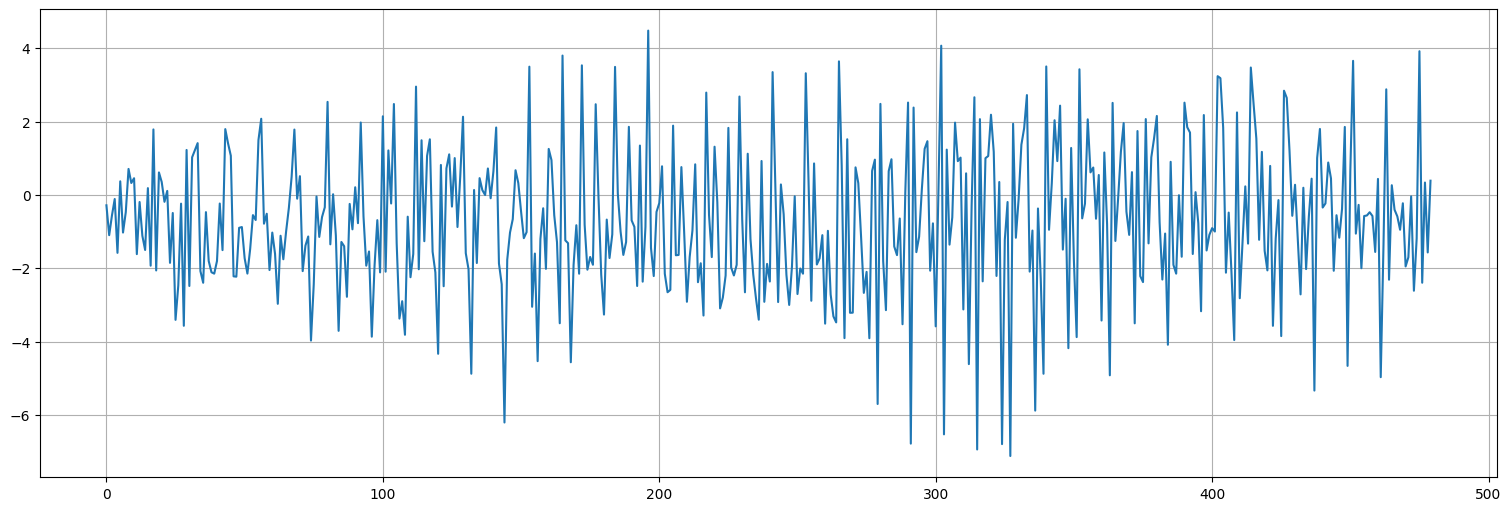

In [39]:
Phi=0.9
coefs = np.concatenate(([1],np.zeros(11),[-Phi]))
print(f"Coeficientes autorregresivos = {coefs}")
x = arma_generate_sample(coefs,[1],480)
x = pd.Series(x)
x.plot();

Miremos la ACF y PACF de esta serie:

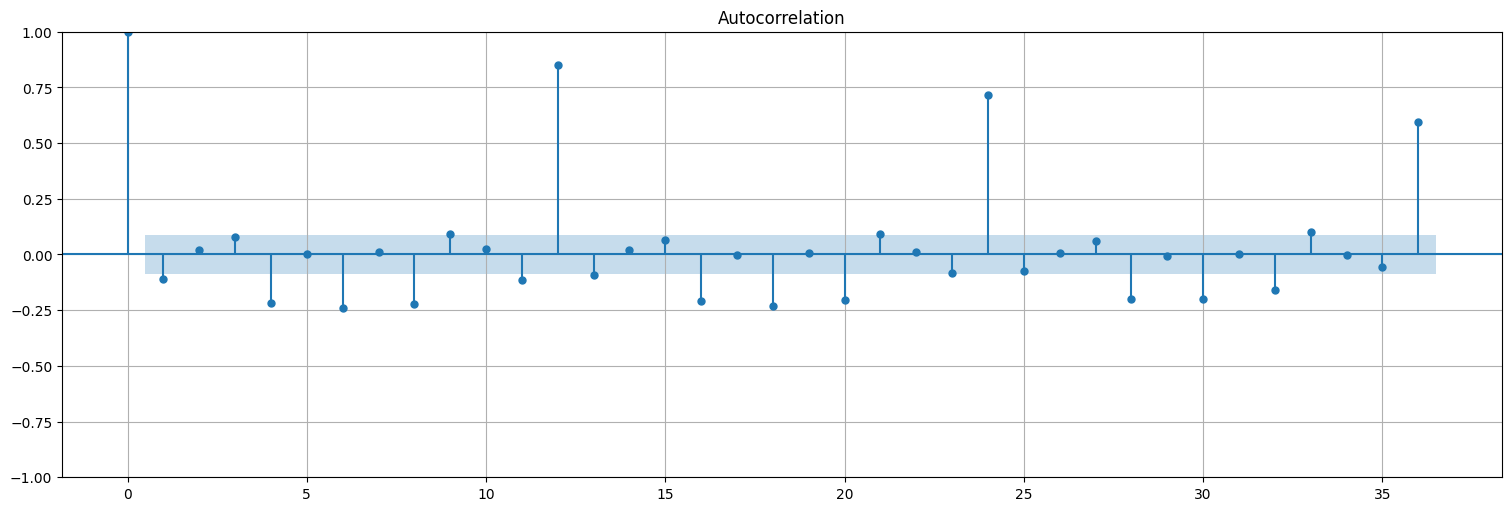

In [40]:
plot_acf(x, lags=36,bartlett_confint=False);

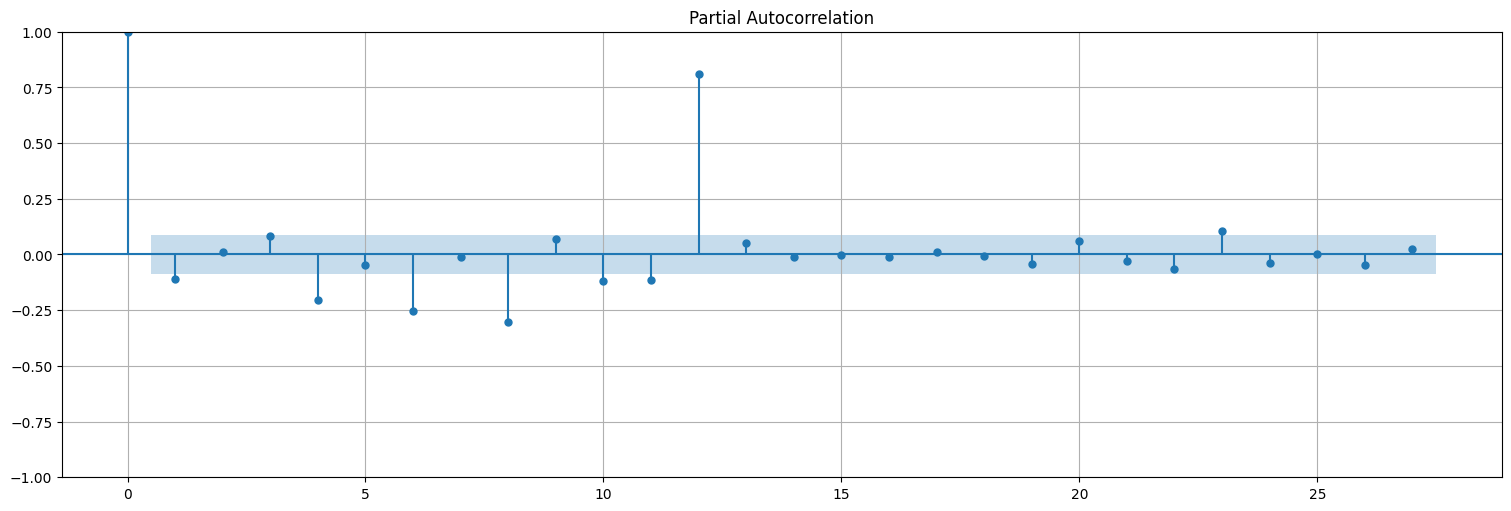

In [41]:
plot_pacf(x);

Y en principio se puede realizar el ajuste de la misma manera que antes:

In [42]:
fit = ARIMA(x,order=(12,0,0), trend="n").fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  480
Model:                ARIMA(12, 0, 0)   Log Likelihood                -695.889
Date:                Thu, 23 May 2024   AIC                           1417.778
Time:                        01:12:55   BIC                           1472.037
Sample:                             0   HQIC                          1439.106
                                - 480                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0172      0.025      0.690      0.490      -0.032       0.066
ar.L2          0.0069      0.026      0.263      0.792      -0.044       0.058
ar.L3          0.0232      0.024      0.963      0.336      -0.024       0.070
ar.L4         -0.0183      0.025     -0.741      0.459      -0.067       0.030
ar.L5          0.0120      0.025      0.482      0.630      -0.037       0.061
ar.L6         -0.0219      0.023     -0.935      0.350      -0.068       0.024
ar.L7          0.0236      0.024      0.989      0.323      -0.023       0.070
ar.L8         -0.0238      0.026     -0.932      0.351      -0.074       0.026
ar.L9          0.0489      0.024      2.037      0.042       0.002       0.096
ar.L10         0.0091      0.024      0.376      0.707      -0.038       0.057
ar.L11        -0.0008      0.023     -0.036      0.972      -0.046       0.044
ar.L12         0.8412      0.023     36.579      0.000       0.796       0.886
sigma2         1.0292      0.068     15.102      0.000       0.896       1.163
===================================================================================
Ljung-Box (L1) (Q):                   1.04   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.31   Prob(JB):                         0.85
Heteroskedasticity (H):               1.08   Skew:                             0.06
Prob(H) (two-sided):                  0.64   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Sin embargo, si uno sabe que los coeficientes son $0$, es mejor obviarlos para lograr un mejor ajuste del coeficiente no nulo. Esto se logra proponiendo un modelo $ARMA(p,q)\times(P,Q)_s$. Aquí $(p,q)$ son las componentes ARMA como antes, y $(P,Q)_s$ indican dependencia a estaciones pasadas (dadas por el período $s$).

En la función `ARIMA` de `statsmodels` esto se hace pasándole el parámetro `seasonal_order=(P,D,Q,s)` donde $P$ es la parte autorregresiva estacional, $D$ la diferenciación estacional (no va en este caso), $Q$ la parte media móvil estacional, y $s$ el período, en este caso $12$.

In [43]:
fit = ARIMA(x,order=(0,0,0), seasonal_order=(1, 0, 0, 12),trend="n").fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  480
Model:             ARIMA(1, 0, 0, 12)   Log Likelihood                -700.137
Date:                Thu, 23 May 2024   AIC                           1404.274
Time:                        01:12:55   BIC                           1412.622
Sample:                             0   HQIC                          1407.556
                                - 480                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8666      0.019     44.557      0.000       0.828       0.905
sigma2         1.0456      0.066     15.761      0.000       0.916       1.176
===================================================================================
Ljung-Box (L1) (Q):                   0.80   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.37   Prob(JB):                         0.93
Heteroskedasticity (H):               1.07   Skew:                             0.01
Prob(H) (two-sided):                  0.67   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Ejemplo: combinación de AR estacional y MA local.

Consideremos el proceso:

$$x_t = \Phi x_{t-12} + w_t + \theta w_{t-1}$$

En este caso tenemos un proceso $ARMA(0,1)\times(1,0)_{12}$.

Consideremos la siguiente serie de nacimientos en EEUU durante el "baby boom":

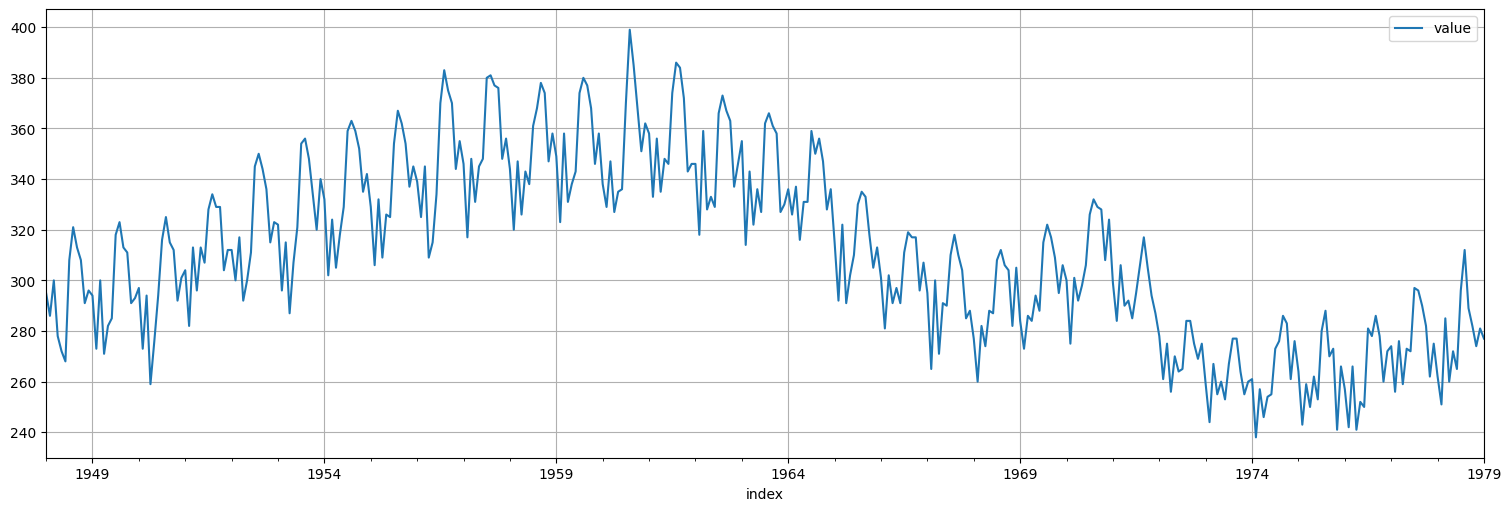

In [44]:
birth = astsa.birth
birth.plot();

Diferenciemos una vez para lograr estacionariedad:

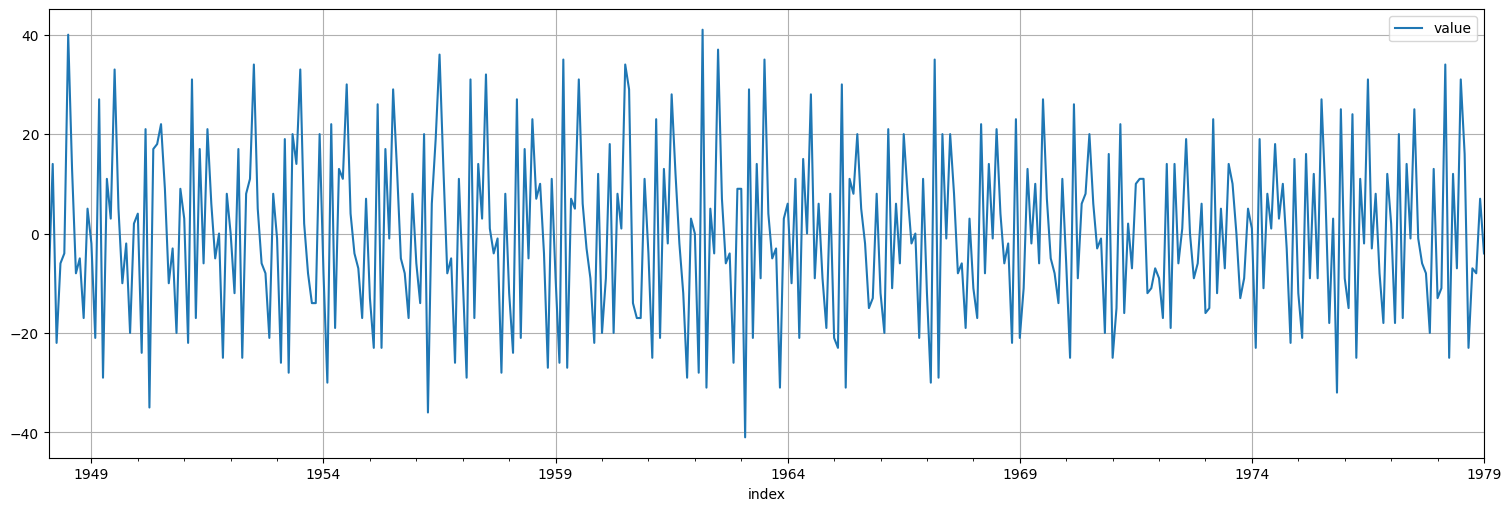

In [45]:
x = birth.diff().dropna()
x.plot();

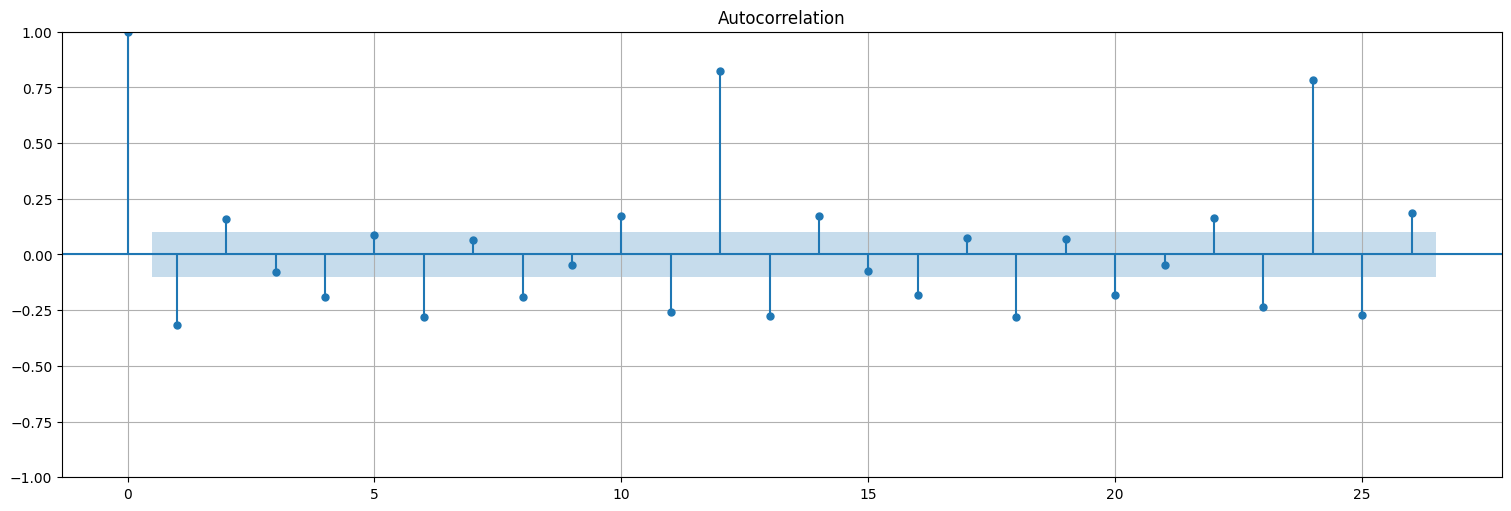

In [46]:
plot_acf(x, bartlett_confint=False);

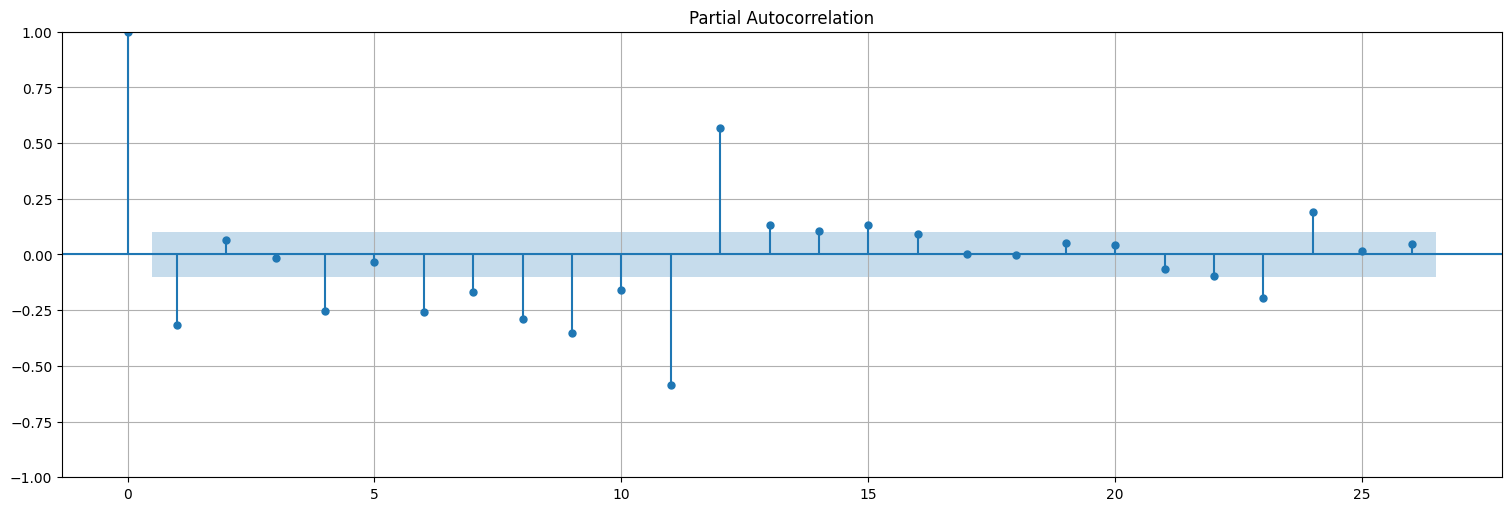

In [47]:
plot_pacf(x);

Ajustamos ahora el modelo anterior $x_t = \Phi x_{t-12} + w_t + \theta w_{t-1}$, es decir, $ARMA(0,1)\times(1,0)_{12}$.

In [48]:
fit = ARIMA(x,order=(0,0,1), seasonal_order=(1, 0, 0, 12),trend="n").fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             value   No. Observations:                  372
Model:             ARIMA(0, 0, 1)x(1, 0, [], 12)   Log Likelihood               -1318.522
Date:                           Thu, 23 May 2024   AIC                           2643.044
Time:                                   01:12:56   BIC                           2654.801
Sample:                               02-29-1948   HQIC                          2647.713
                                    - 01-31-1979                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5035      0.043    -11.823      0.000      -0.587      -0.420
ar.S.L12       0.8697      0.023     37.533      0.000       0.824       0.915
sigma2        66.9941      4.620     14.500      0.000      57.939      76.049
===================================================================================
Ljung-Box (L1) (Q):                   2.76   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.10   Prob(JB):                         0.39
Heteroskedasticity (H):               0.99   Skew:                             0.11
Prob(H) (two-sided):                  0.94   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Agreguemos una predicción a futuro:

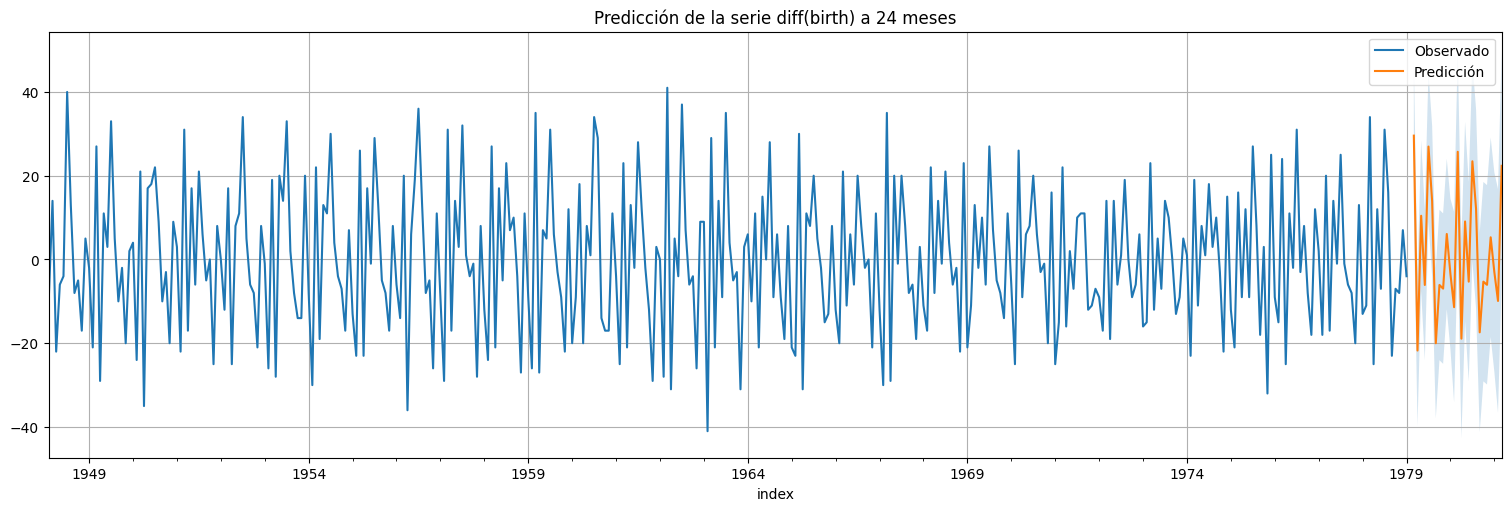

In [49]:
#Usamos el modelo ajustado para predecir a futuro
h = 24 #horizonte de predicción
predicciones = fit.get_prediction(start=birth.size,end=birth.size+h)
xhat = predicciones.predicted_mean
confint = predicciones.conf_int(alpha=0.05) #alpha es la confianza del intervalo
x.plot()
xhat.plot()
plt.legend(["Observado","Predicción"])
plt.fill_between(xhat.index,confint["lower value"], confint["upper value"], alpha=0.2);
plt.title(f"Predicción de la serie diff(birth) a {h} meses");

### Modelo SARIMA general

En el ejemplo anterior, tuvimos que *diferenciar* la serie `birth` para lograr algo estacionario. Esto nos lleva al modelo SARIMA general, en el cual los parámetros son:

* $(p,d,q)$, las componentes locales del modelo sarima. $d$ es la cantidad de veces que hay que diferenciar con la muestra anterior.
* $(P,D,Q)$, las componentes estacionales del modelo sarima. $D$ es la cantidad de veces que hay que diferenciar con la estación anterior.
* $s$ es la frecuencia de las estaciones.

Para el caso anterior, podemos directamente ajustar un modelo $SARIMA(0,1,1)\times (1,0,0)_{12}$ pasándole el problema de diferenciar al ajuste.

In [50]:
birth
fit = ARIMA(birth,order=(0,1,1), seasonal_order=(1, 0, 0, 12),trend="n").fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             value   No. Observations:                  373
Model:             ARIMA(0, 1, 1)x(1, 0, [], 12)   Log Likelihood               -1318.523
Date:                           Thu, 23 May 2024   AIC                           2643.046
Time:                                   01:12:57   BIC                           2654.803
Sample:                               01-31-1948   HQIC                          2647.715
                                    - 01-31-1979                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5035      0.043    -11.823      0.000      -0.587      -0.420
ar.S.L12       0.8697      0.023     37.533      0.000       0.824       0.915
sigma2        66.9942      4.620     14.500      0.000      57.939      76.050
===================================================================================
Ljung-Box (L1) (Q):                   2.76   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.10   Prob(JB):                         0.39
Heteroskedasticity (H):               0.99   Skew:                             0.11
Prob(H) (two-sided):                  0.94   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

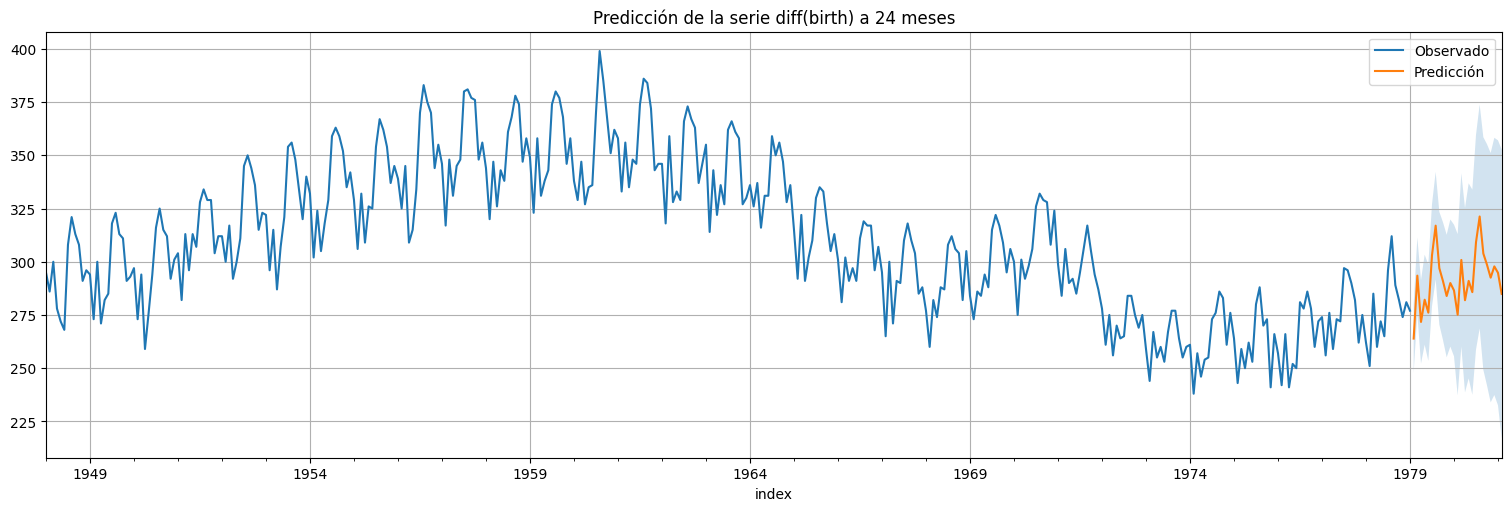

In [51]:
#Usamos el modelo ajustado para predecir a futuro
h = 24 #horizonte de predicción
predicciones = fit.get_prediction(start=birth.size,end=birth.size+h)
xhat = predicciones.predicted_mean
confint = predicciones.conf_int(alpha=0.05) #alpha es la confianza del intervalo
birth.plot()
xhat.plot()
plt.legend(["Observado","Predicción"])
plt.fill_between(xhat.index,confint["lower value"], confint["upper value"], alpha=0.2);
plt.title(f"Predicción de la serie diff(birth) a {h} meses");

## Modelos GARCH

Esta familia de modelos permiten modelar series cuya **varianza** no es estacionaria, como la que vimos anteriormente para el EUR vs USD

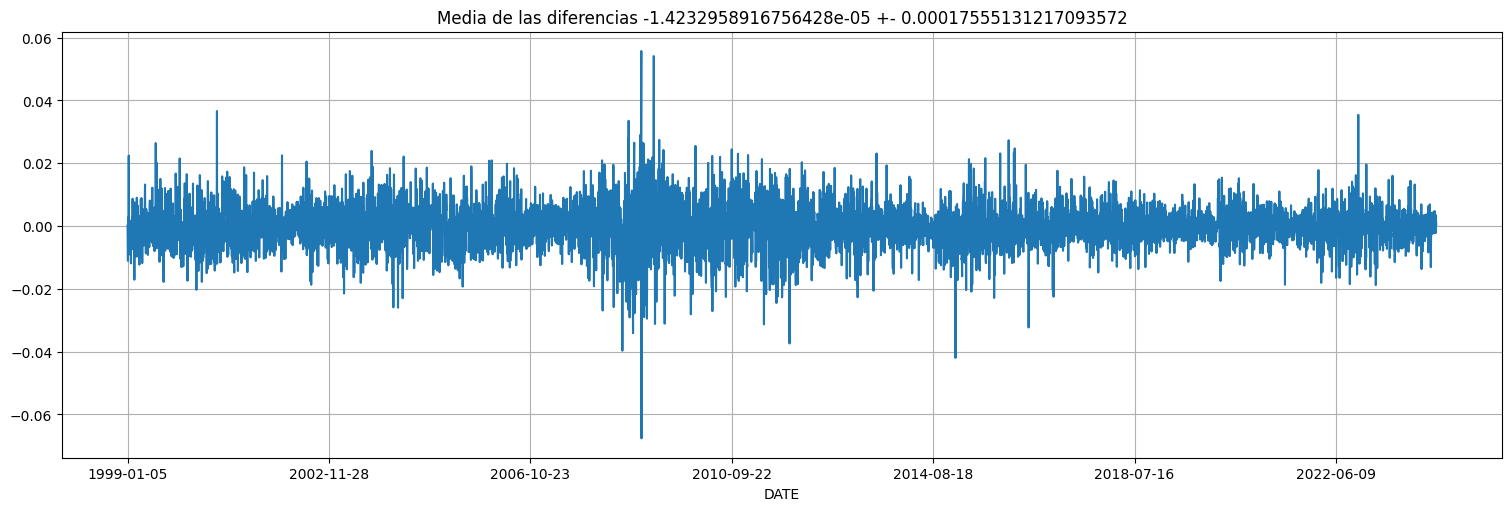

In [52]:
y = eur.diff().dropna()
y.plot();
plt.title(f"Media de las diferencias {np.mean(y)} +- {2*np.std(y)/np.sqrt(y.size)}");

### Idea:

Modelar la **varianza** de la serie como un proceso autorregresivo. Si la serie está centrada, esto es equivalente a ajustar un modelo ARMA a los valores de $x_t^2$. Este modelo se llama $GARCH$: Generalized autorregressive conditionally heteroskedastic.

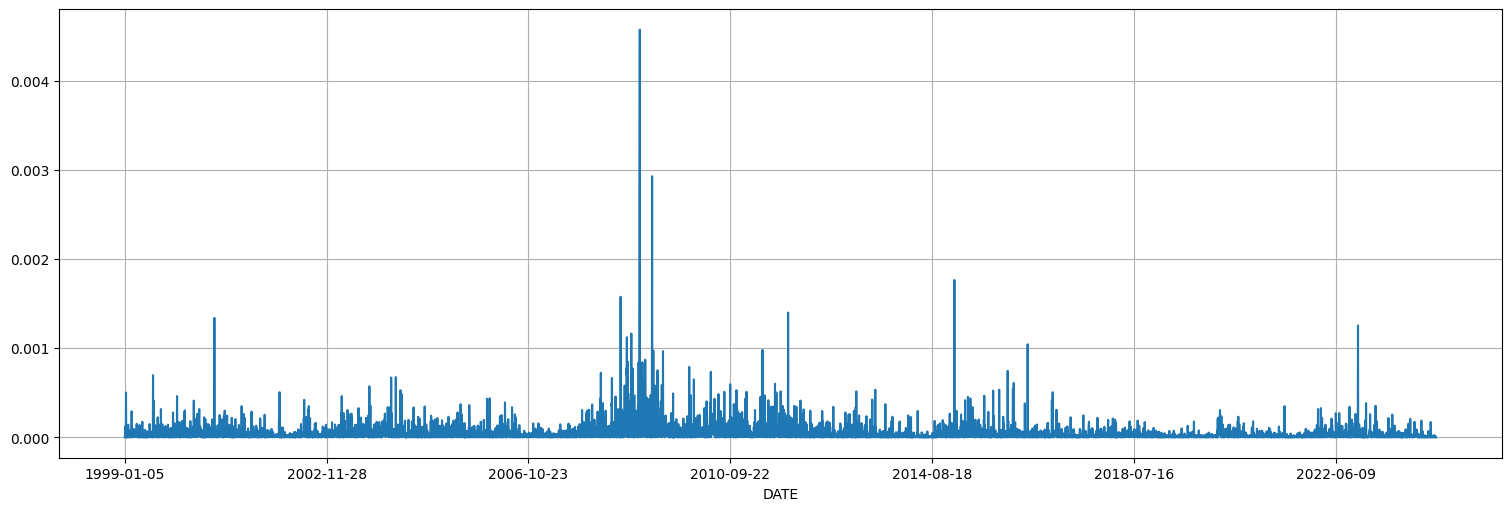

In [53]:
y2 = y**2
y2.plot();

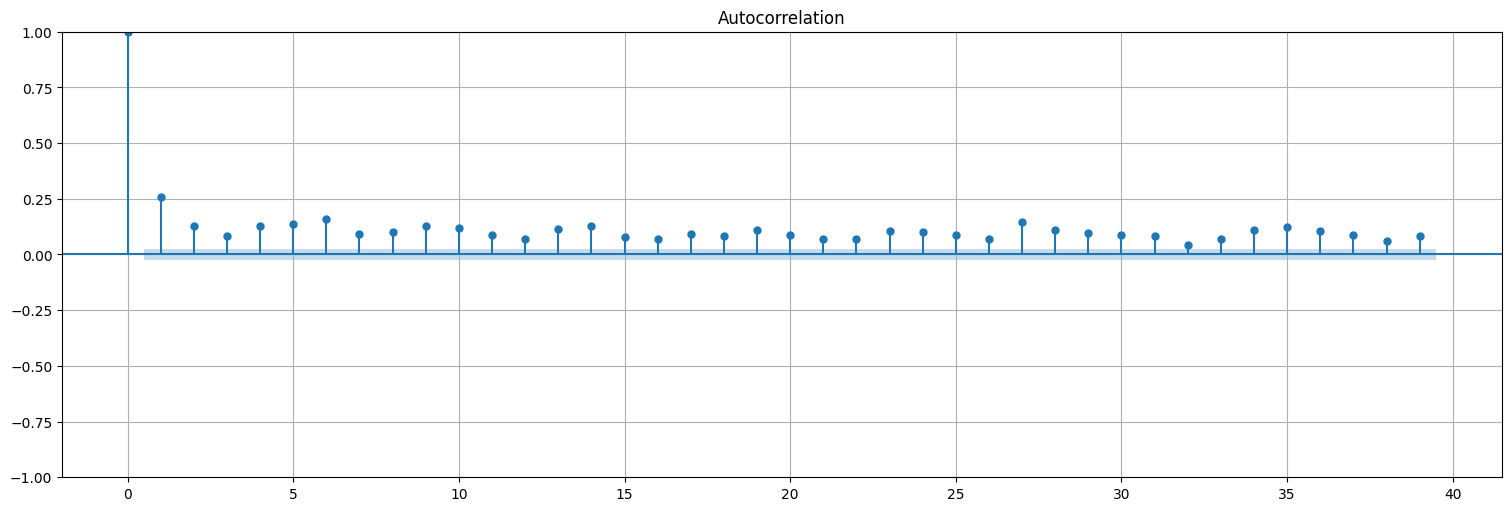

In [54]:
plot_acf(y2,bartlett_confint=False);

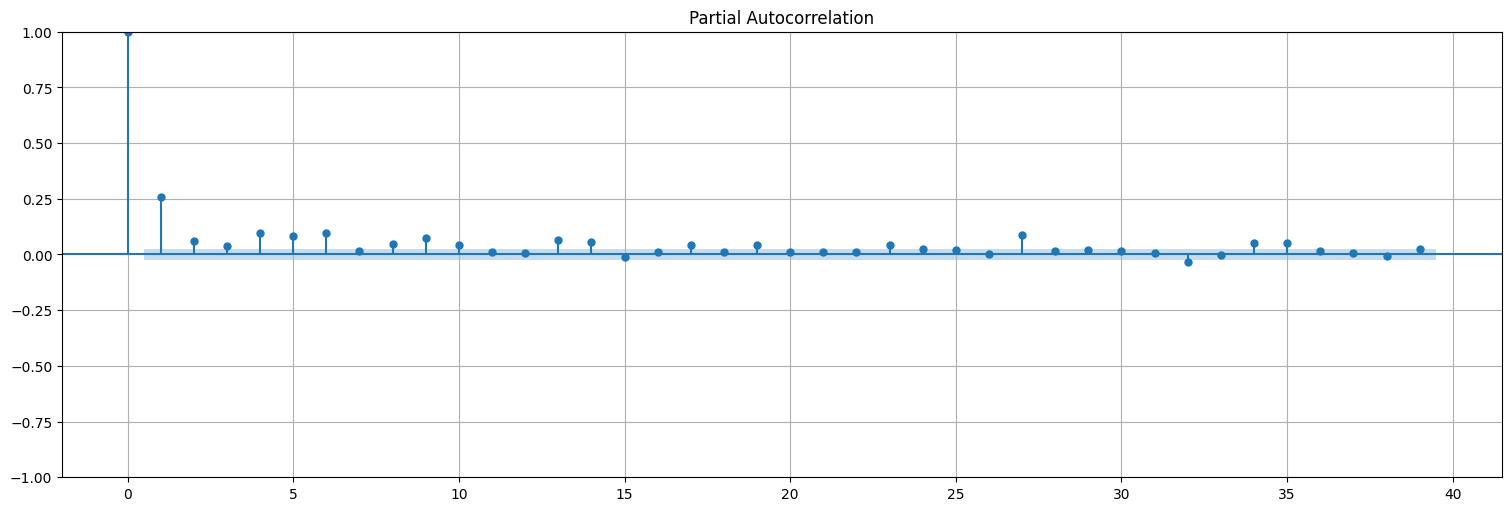

In [55]:
plot_pacf(y2);

La biblioteca statsmodels no incluye modelos tipo GARCH por lo que requerimos la biblioteca `arch`

In [56]:
from arch import arch_model
fit = arch_model(y, mean='Zero', vol='GARCH', p=1,q=1, rescale=True).fit();
fit.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 3542121476.1780243
Iteration:      2,   Func. Count:     12,   Neg. LLF: 6432.502659518372
Iteration:      3,   Func. Count:     16,   Neg. LLF: 13054.959746032848
Iteration:      4,   Func. Count:     21,   Neg. LLF: 8158.435263516078
Iteration:      5,   Func. Count:     28,   Neg. LLF: 9558.501773006285
Iteration:      6,   Func. Count:     33,   Neg. LLF: 8654.91314452406
Iteration:      7,   Func. Count:     39,   Neg. LLF: 7699.191400682974
Iteration:      8,   Func. Count:     45,   Neg. LLF: 6407.881624706548
Iteration:      9,   Func. Count:     49,   Neg. LLF: 6407.647767369655
Iteration:     10,   Func. Count:     53,   Neg. LLF: 6407.62097092969
Iteration:     11,   Func. Count:     57,   Neg. LLF: 6407.619060417868
Iteration:     12,   Func. Count:     61,   Neg. LLF: 6407.618973525465
Iteration:     13,   Func. Count:     64,   Neg. LLF: 6407.618973521758
Optimization terminated successfully    (Exit mode 0)
          

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6407.62
Distribution:                  Normal   AIC:                           12821.2
Method:            Maximum Likelihood   BIC:                           12841.6
                                        No. Observations:                 6499
Date:                Thu, May 23 2024   Df Residuals:                     6499
Time:                        01:12:58   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.2267e-03  5.081e-04      2.414  1.577e-02 [2.309e-04,2.223e-03]
alpha[1]       0.0282  3.649e-03      7.720  1.168e-14 [2.102e-02,3.532e-02]
beta[1]        0.9694  3.914e-03    247.714      0.000     [  0.962,  0.977]
============================================================================

Covariance estimator: robust
"""

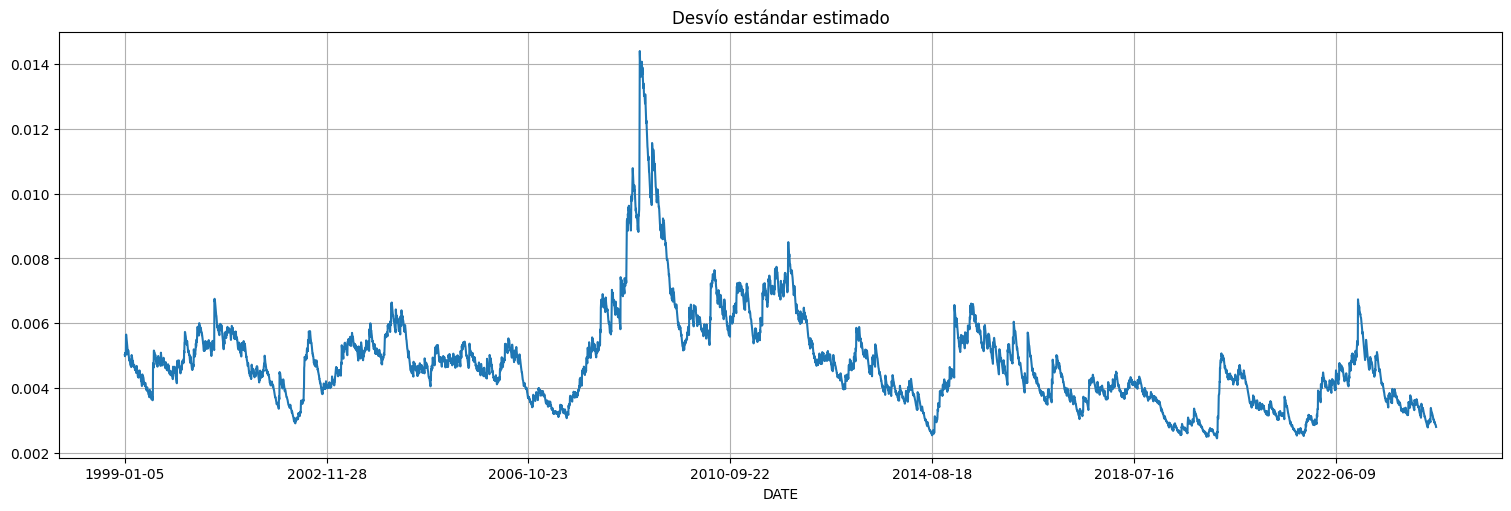

In [57]:
#Obtenemos los valores de varianza estimada por el modelo ajustado
#Horizon=1 es que predice el valor siguiente, start=0 es que arranca al comienzo de la serie)
predicciones = fit.forecast(horizon=1,start=0).variance
predicciones = pd.Series(predicciones["h.1"])
desvio = np.sqrt(predicciones)*np.std(y)
desvio.plot();
plt.title("Desvío estándar estimado");

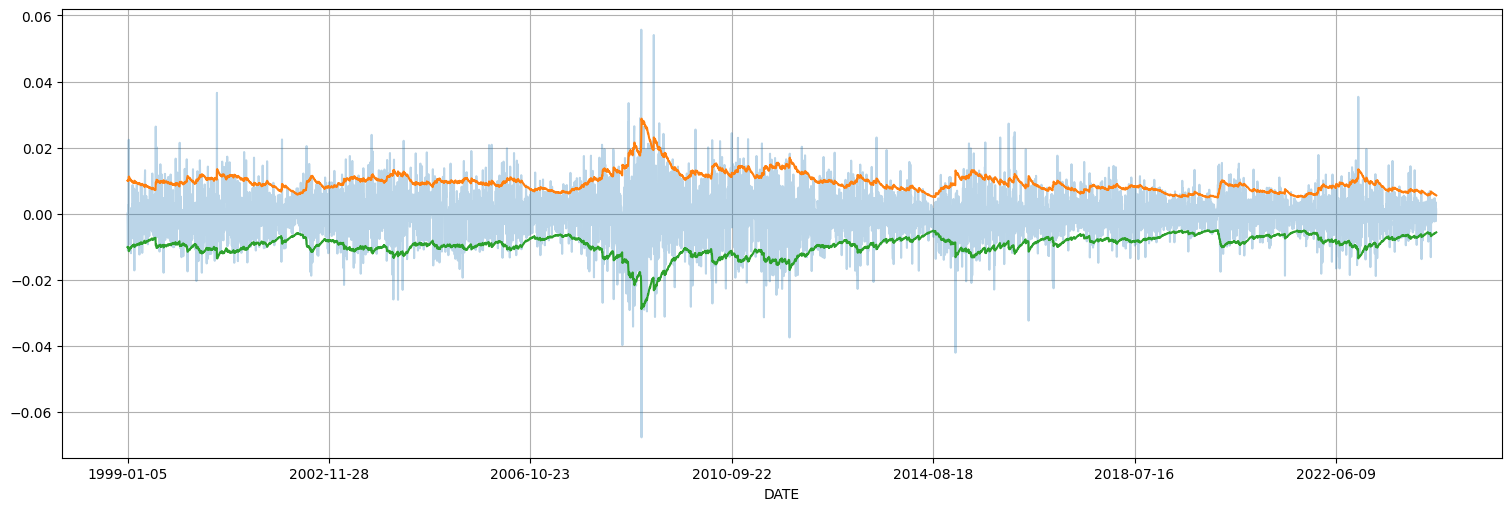

In [58]:
y.plot(alpha=0.3)
(2*desvio).plot()
(-2*desvio).plot();

## Ejercicio

Utilizando la serie `gtemp` de temperaturas globales ya vista anteriormente, ajustar un modelo $ARIMA(p,d,q)$ adecuado utilizando las técnicas anteriores.

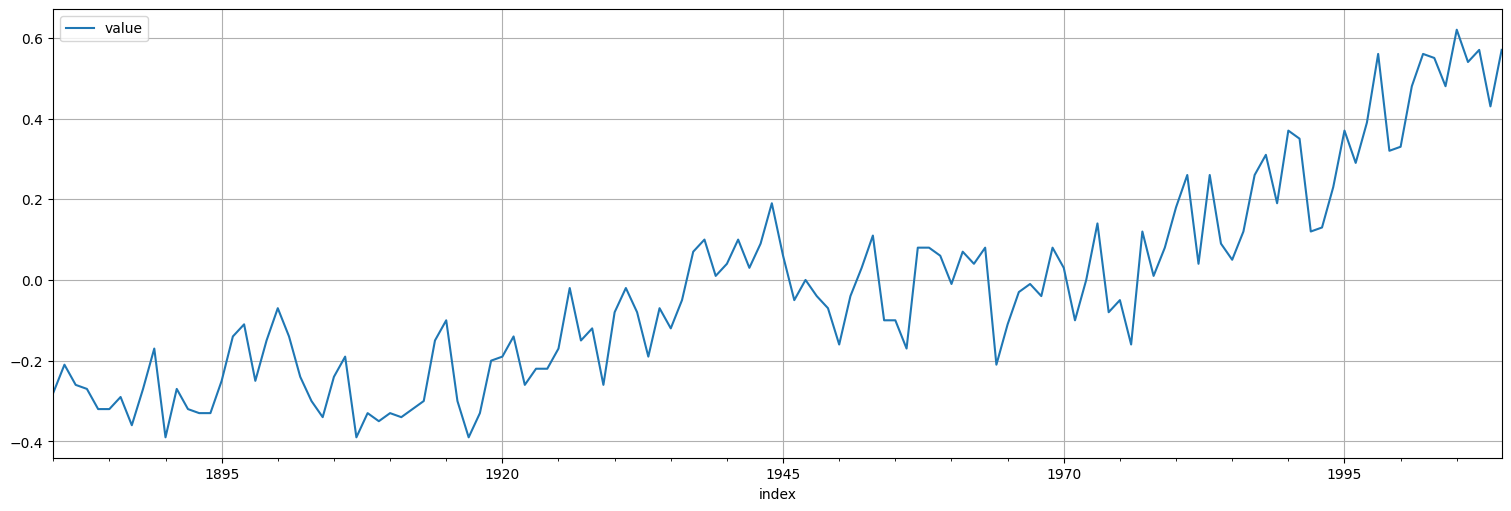

In [59]:
gtemp = astsa.gtemp
gtemp.plot();

## Ejercicio

Utilizando la serie `AirPassengers` vista anteriormente, ajustar un modelo tipo $SARIMA$ adecuado (diferenciando y transformando si es necesario) de estacionalidad $12$. Comparar con los ajustes realizados previamente en base a senos y cosenos.

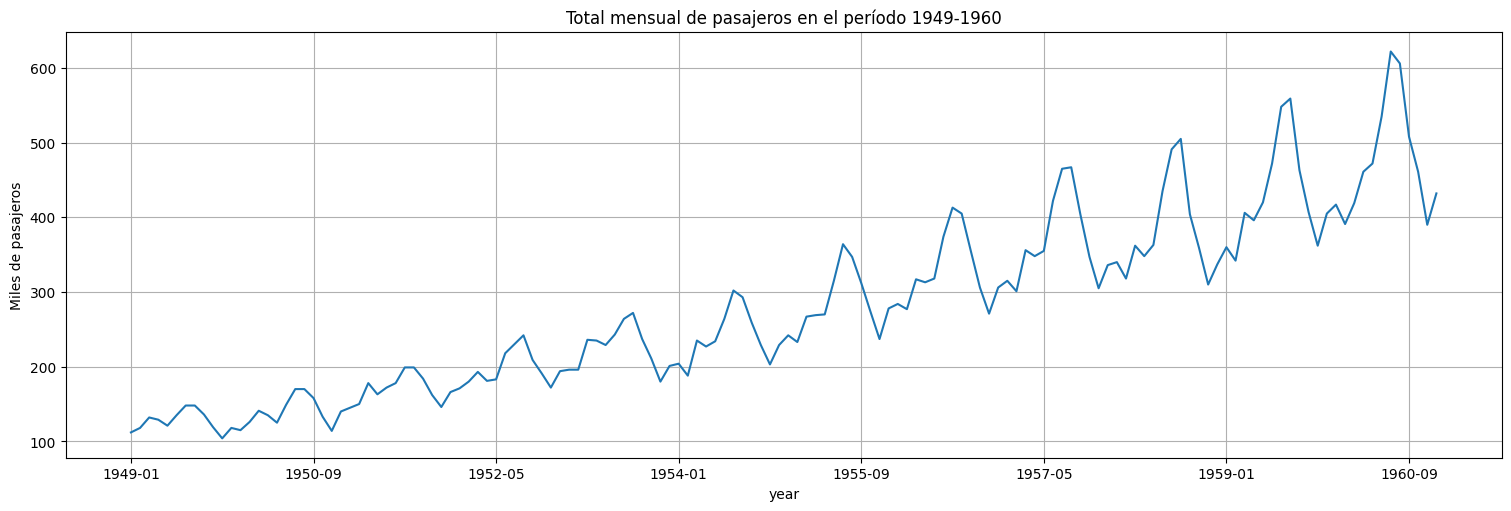

In [60]:
df = pd.read_csv('../data/international-airline-passengers.csv', names = ['year','passengers'], header=0)
air = pd.Series(df["passengers"].values, index=df['year'])
air.plot();
plt.title("Total mensual de pasajeros en el período 1949-1960")
plt.ylabel("Miles de pasajeros");